In [1]:
import os

os.getcwd()

'/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana'

In [2]:
#.. created by Chuyan Tan at June 15th, this file was intended to examine and visualize the sw CLOUD Feedback in Southern Ocean

import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
# import PyNIO as Nio
import pandas as pd
import glob
from scipy.stats import *
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

from area_mean import *
from scipy.optimize import curve_fit
import seaborn as sns
from copy import deepcopy
from useful_func_cy import *


In [3]:
# Read CMIP5/ 6 Cloud feedbacks data

fn_cmip5 = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/CMIP5_cld_fbks.nc'

fn_cmip6 = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/CMIP6_cld_fbkd_July12.nc'

# glob.glob(fn_cmip5)
f_cmip5 = nc.Dataset(fn_cmip5, 'r')

f_cmip6 = nc.Dataset(fn_cmip6, 'r')

print(f_cmip5.variables['model'])

<class 'netCDF4._netCDF4.Variable'>
float64 model(model)
    realtopology: linear
    long_name: ['ACCESS1-0' 'ACCESS1-3' 'BNU-ESM' 'CCSM4' 'CNRM-CM5' 'CSIRO-Mk3-6-0'
 'CanESM2' 'FGOALS-g2' 'FGOALS-s2' 'GFDL-CM3' 'GFDL-ESM2G' 'GFDL-ESM2M'
 'GISS-E2-H' 'GISS-E2-R' 'HadGEM2-ES' 'IPSL-CM5A-LR' 'IPSL-CM5A-MR'
 'IPSL-CM5B-LR' 'MIROC-ESM' 'MIROC5' 'MPI-ESM-LR' 'MPI-ESM-MR' 'MPI-ESM-P'
 'MRI-CGCM3' 'NorESM1-M' 'NorESM1-ME' 'bcc-csm1-1-m' 'bcc-csm1-1' 'inmcm4']
unlimited dimensions: 
current shape = (29,)
filling on, default _FillValue of 9.969209968386869e+36 used


In [4]:
# Calculate 5*5 bin array for variables (LWP, CCFs) in Sounthern Ocean Region:
#..set are-mean range and define function
s_range = arange(-90., 90., 5.) + 2.5  #..global-region latitude edge: (36)
x_range = arange(-180., 180., 5.)  #..logitude sequences edge: number: 72
y_range = arange(-85, -40., 5.) +2.5  #..southern-ocaen latitude edge: 9

path1 = '/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/'
path6 = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/plot_file/plots_Sep8_Observation_data/'

In [5]:
# variables from Zelinka's SWfb files:

lat_mz = np.asarray(f_cmip6.variables['latitude'])
bound_lat_mz = np.asarray(f_cmip6.variables['bounds_latitude'])

lon_mz = np.asarray(f_cmip6.variables['longitude'])
bound_lon_mz = np.asarray(f_cmip6.variables['bounds_longitude'])
# print(lon_mz)

# model_names:
cmip6model_nas = f_cmip6.variables['model'].long_name
cmip5model_nas = f_cmip5.variables['model'].long_name

cmip6_nas = cmip6model_nas[1:-1].split()
for i in range(len(cmip6_nas)):
    cmip6_nas[i] = cmip6_nas[i][1:-1]
    
cmip5_nas = cmip5model_nas[1:-1].split()
for i in range(len(cmip5_nas)):
    cmip5_nas[i] = cmip5_nas[i][1:-1]
# print(cmip6_nas)
# print(cmip5_nas)

model_nas = []
model_nas = np.append(cmip6_nas, cmip5_nas)
print(model_nas.shape)

# SW_cloud_Feedback:
sw_cld_fb_mz = []
cmip6_sw_cld_fb_mz = np.asarray(f_cmip6.variables['SWCLD_fbk6_map'])

cmip5_sw_cld_fb_mz = np.asarray(f_cmip5.variables['SWCLD_fbk5_map'])

sw_cld_fb_mz = np.append(cmip6_sw_cld_fb_mz, cmip5_sw_cld_fb_mz, axis =2)
print(sw_cld_fb_mz.shape)


(79,)
(90, 144, 79)


In [6]:
print(lat_mz)

[-89. -87. -85. -83. -81. -79. -77. -75. -73. -71. -69. -67. -65. -63.
 -61. -59. -57. -55. -53. -51. -49. -47. -45. -43. -41. -39. -37. -35.
 -33. -31. -29. -27. -25. -23. -21. -19. -17. -15. -13. -11.  -9.  -7.
  -5.  -3.  -1.   1.   3.   5.   7.   9.  11.  13.  15.  17.  19.  21.
  23.  25.  27.  29.  31.  33.  35.  37.  39.  41.  43.  45.  47.  49.
  51.  53.  55.  57.  59.  61.  63.  65.  67.  69.  71.  73.  75.  77.
  79.  81.  83.  85.  87.  89.]


In [7]:
# Southern Ocean sw_cloud_FB :
lati0 = -85.
latsi0 = min(range(len(lat_mz)), key = lambda i: abs(lat_mz[i] - lati0))
lati1 = -40.
latsi1 = min(range(len(lat_mz)), key = lambda i: abs(lat_mz[i] - lati1))
lati2 = -50.
latsi2 = min(range(len(lat_mz)), key = lambda i: abs(lat_mz[i] - lati2))

print("latitude index for -85.s -40.s and -50.s:", latsi0, latsi1, latsi2)
# print(lat_mz[latsi0], lat_mz[latsi1+1], lat_mz[latsi2+1])

# Handle nan value
sw_cld_fb_mz = np.where(sw_cld_fb_mz!=1.e+20, sw_cld_fb_mz, np.nan)
ind_nan = np.isnan(sw_cld_fb_mz)
# print(np.nonzero(ind_nan==True))  # #0

# SO_sw_cldfb
# SO_sw_cldfb = np.nanmean(sw_cld_fb_mz[(latsi0+1):(latsi1+1),:,:], axix = (0, 1)) # -84.S ~ -40.S

# x_range & y_range:
y_range_swcld = lat_mz[(latsi0):(latsi1+1+1)]
y_range_swcld4050 = lat_mz[(latsi2+1):(latsi1+1+1)]
y_range_swcld5085 = lat_mz[(latsi0):(latsi2+1+1)]
x_range_swcld = lon_mz

print(y_range_swcld, y_range_swcld4050)

reshape_sw_cld_fb = np.transpose(sw_cld_fb_mz,(2, 0, 1))
# SO_sw_cldfb = area_mean(reshape_sw_cld_fb[:,(latsi0):(latsi1+1+1),:], y_range_swcld, x_range_swcld) # -85.S ~ -40.S
SO_sw_cldfb = latitude_mean(reshape_sw_cld_fb[:,:,:], lat_mz, lon_mz, lat_range=[-85., -40.])
# SO_sw_cldfb_5085 = area_mean(reshape_sw_cld_fb[:,(latsi0):(latsi2+1+1),:], y_range_swcld5085, x_range_swcld) # -85.S ~ -50.S
SO_sw_cldfb_5085 = latitude_mean(reshape_sw_cld_fb[:,:,:], lat_mz, lon_mz, lat_range=[-85., -50.])
# SO_sw_cldfb_4050 = area_mean(reshape_sw_cld_fb[:,(latsi2+1):(latsi1+1+1),:], y_range_swcld4050, x_range_swcld) # -50.S ~ -40.S
SO_sw_cldfb_4050 = latitude_mean(reshape_sw_cld_fb[:,:,:], lat_mz, lon_mz, lat_range=[-50., -40.])

print(SO_sw_cldfb.shape)


latitude index for -85.s -40.s and -50.s: 2 24 19
[-85. -83. -81. -79. -77. -75. -73. -71. -69. -67. -65. -63. -61. -59.
 -57. -55. -53. -51. -49. -47. -45. -43. -41. -39.] [-49. -47. -45. -43. -41. -39.]
(79,)


In [ ]:
# Needed CMIP6 GCM names:
print(model_nas[31])
order_of_GCM_July12 = [2, 4, 16, 6, 7, 8, 9, 11, 15, 13, 14, 17, 18, 20, 22, 23, 5, 34, 31,  41, 42, 25, 26, 27, 38, 37, 43, 46, 47, 48]

In [8]:
lat_mz = np.asarray(f_cmip6.variables['latitude'])
bound_lat_mz = np.asarray(f_cmip6.variables['bounds_latitude'])

print(np.asarray(lat_mz).shape)
print(np.asarray(bound_lat_mz))

(90,)
[[-90. -88.]
 [-88. -86.]
 [-86. -84.]
 [-84. -82.]
 [-82. -80.]
 [-80. -78.]
 [-78. -76.]
 [-76. -74.]
 [-74. -72.]
 [-72. -70.]
 [-70. -68.]
 [-68. -66.]
 [-66. -64.]
 [-64. -62.]
 [-62. -60.]
 [-60. -58.]
 [-58. -56.]
 [-56. -54.]
 [-54. -52.]
 [-52. -50.]
 [-50. -48.]
 [-48. -46.]
 [-46. -44.]
 [-44. -42.]
 [-42. -40.]
 [-40. -38.]
 [-38. -36.]
 [-36. -34.]
 [-34. -32.]
 [-32. -30.]
 [-30. -28.]
 [-28. -26.]
 [-26. -24.]
 [-24. -22.]
 [-22. -20.]
 [-20. -18.]
 [-18. -16.]
 [-16. -14.]
 [-14. -12.]
 [-12. -10.]
 [-10.  -8.]
 [ -8.  -6.]
 [ -6.  -4.]
 [ -4.  -2.]
 [ -2.   0.]
 [  0.   2.]
 [  2.   4.]
 [  4.   6.]
 [  6.   8.]
 [  8.  10.]
 [ 10.  12.]
 [ 12.  14.]
 [ 14.  16.]
 [ 16.  18.]
 [ 18.  20.]
 [ 20.  22.]
 [ 22.  24.]
 [ 24.  26.]
 [ 26.  28.]
 [ 28.  30.]
 [ 30.  32.]
 [ 32.  34.]
 [ 34.  36.]
 [ 36.  38.]
 [ 38.  40.]
 [ 40.  42.]
 [ 42.  44.]
 [ 44.  46.]
 [ 46.  48.]
 [ 48.  50.]
 [ 50.  52.]
 [ 52.  54.]
 [ 54.  56.]
 [ 56.  58.]
 [ 58.  60.]
 [ 60.  62.]
 [ 62.

In [7]:
x, y = np.ogrid[:3, :4]
print(y.shape)

(1, 4)


In [8]:
# Model list (Global Climate Model);

exp = 'piControl'

# CMIP6: 31 (30: BCCCSMCM2MR)
AWICM11MR = {'modn': 'AWI-CM-1-1-MR', 'consort': 'AWI', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
BCCCSMCM2MR = {'modn': 'BCC-CSM2-MR', 'consort': 'BCC', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
BCCESM1 = {'modn': 'BCC-ESM1', 'consort': 'BCC', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CAMSCSM1 = {'modn': 'CAMS-CSM1-0', 'consort': 'CAMS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CMCCCM2SR5 = {'modn': 'CMCC-CM2-SR5', 'consort': 'CMCC', 'cmip': 'cmip6', 
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2 = {'modn': 'CESM2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2FV2 = {'modn': 'CESM2-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2WACCM = {'modn': 'CESM2-WACCM', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2WACCMFV2 = {'modn': 'CESM2-WACCM-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

CNRMCM61 = {'modn': 'CNRM-CM6-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
               'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CNRMCM61HR = {'modn': 'CNRM-CM6-1-HR', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CNRMESM21 = {'modn': 'CNRM-ESM2-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CanESM5 = {'modn': 'CanESM5', 'consort': 'CCCma', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
E3SM10 = {'modn': 'E3SM-1-0', 'consort': 'E3SM-Project', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}

ECEarth3 = {'modn': 'EC-Earth3', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
ECEarth3Veg = {'modn': 'EC-Earth3-Veg', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}

FGOALSg3 = {'modn': 'FGOALS-g3', 'consort': 'CAS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21G = {'modn': 'GISS-E2-1-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21H = {'modn': 'GISS-E2-1-H', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE22G = {'modn': 'GISS-E2-2-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GFDLCM4 = {'modn': 'GFDL-CM4', 'consort': 'NOAA-GFDL', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}
# HADGEM3 = {'modn': 'HadGEM3-GC31-LL', 'consort': 'MOHC', 'cmip': 'cmip6',
#             'exper': 'piControl', 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}   #..missing 'wap' in 'piControl' exp(Daniel says that HadGEM3-GC31 not using p-level, so doesn't have variables on p-level
INM_CM48 = {'modn': 'INM-CM4-8', 'consort': 'INM', 'cmip': 'cmip6', 
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}
IPSLCM6ALR = {'modn': 'IPSL-CM6A-LR', 'consort': 'IPSL', 'cmip': 'cmip6',
                  'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
MIROCES2L = {'modn': 'MIROC-ES2L', 'consort': 'MIROC', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gn', "typevar": 'Amon'}
MIROC6 = {'modn': 'MIROC6', 'consort': 'MIROC', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MPIESM12LR = {'modn': 'MPI-ESM1-2-LR', 'consort': 'MPI-M', 'cmip': 'cmip6',
                  'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MRIESM20 = {'modn': 'MRI-ESM2-0', 'consort': 'MRI', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
NESM3 = {'modn': 'NESM3', 'consort': 'NUIST', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
NorESM2MM = {'modn': 'NorESM2-MM', 'consort': 'NCC', 'cmip': 'cmip6',
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
SAM0 = {'modn': 'SAM0-UNICON', 'consort': 'SNU', 'cmip': 'cmip6', 
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
TaiESM1 = {'modn': 'TaiESM1', 'consort': 'AS-RCEC', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

# CMIP5: 20 (18, ACCESS10, ACCESS13)
ACCESS10 = {'modn': 'ACCESS1-0', 'consort': 'CSIRO-BOM', 'cmip': 'cmip5',   # 2-d (145) and 3-d (146) variables have different lat shape
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
ACCESS13 = {'modn': 'ACCESS1-3', 'consort': 'CSIRO-BOM', 'cmip': 'cmip5',   # 2-d (145) and 3-d (146) variables have different lat shape
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
BNUESM = {'modn': 'BNU-ESM', 'consort': 'BNU', 'cmip': 'cmip5',
          'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}

CCSM4 = {'modn': 'CCSM4', 'consort': 'NCAR', 'cmip': 'cmip5',
             'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CNRMCM5 = {'modn': 'CNRM-CM5', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CSIRO_Mk360 = {'modn': 'CSIRO-Mk3-6-0', 'consort': 'CSIRO-QCCCE', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CanESM2 = {'modn': 'CanESM2', 'consort': 'CCCma', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
FGOALSg2 = {'modn': 'FGOALS-g2', 'consort': 'LASG-CESS', 'cmip': 'cmip5',   # missing 'prw' in piControl
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
FGOALSs2 = {'modn': 'FGOALS-s2', 'consort': 'LASG-IAP', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLCM3 = {'modn': 'GFDL-CM3', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GISSE2H = {'modn': 'GISS-E2-H', 'consort': 'NASA-GISS', 'cmip': 'cmip5',
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GISSE2R = {'modn': 'GISS-E2-R', 'consort': 'NASA-GISS', 'cmip': 'cmip5',
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
IPSLCM5ALR = {'modn': 'IPSL-CM5A-LR', 'consort': 'IPSL', 'cmip': 'cmip5',
               'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MIROC5 = {'modn': 'MIROC5', 'consort': 'MIROC', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MPIESMMR = {'modn': 'MPI-ESM-MR', 'consort': 'MPI-M', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
NorESM1M = {'modn': 'NorESM1-M', 'consort': 'NCC', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}

MIROCESM = {'modn': 'MIROC-ESM', 'consort': 'MIROC', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MRICGCM3 = {'modn': 'MRI-CGCM3', 'consort': 'MRI', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MPIESMLR = {'modn': 'MPI-ESM-LR', 'consort': 'MPI-M', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
bcccsm11 = {'modn': 'bcc-csm1-1', 'consort': 'BCC', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLESM2G = {'modn': 'GFDL-ESM2G', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLESM2M = {'modn': 'GFDL-ESM2M', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5', 
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}


In [9]:
deck2 = [BCCESM1, CanESM5, CESM2, CESM2FV2, CESM2WACCM, CNRMESM21, CNRMCM61HR, GISSE21G, GISSE21H, IPSLCM6ALR, MRIESM20, MIROC6, SAM0, E3SM10, FGOALSg3, GFDLCM4, CAMSCSM1, INM_CM48, MPIESM12LR, AWICM11MR, CMCCCM2SR5, CESM2WACCMFV2, CNRMCM61, ECEarth3, ECEarth3Veg, GISSE22G, MIROCES2L, NESM3, NorESM2MM, TaiESM1, BNUESM, CCSM4, CNRMCM5, CSIRO_Mk360, CanESM2, FGOALSg2, FGOALSs2, GFDLCM3, GISSE2H, GISSE2R, IPSLCM5ALR, MIROC5, MPIESMMR, NorESM1M, MIROCESM, MRICGCM3, MPIESMLR, bcccsm11, GFDLESM2G, GFDLESM2M]   # current # 30 (no.19) + 20 = 50
deck_nas2 = ['BCCESM1', 'CanESM5', 'CESM2', 'CESM2FV2', 'CESM2WACCM', 'CNRMESM21', 'CNRMCM61HR', 'GISSE21G', 'GISSE21H', 'IPSLCM6ALR', 'MRIESM20', 'MIROC6', 'SAM0', 'E3SM10', 'FGOALSg3', 'GFDLCM4', 'CAMSCSM1', 'INM_CM48', 'MPIESM12LR', 'AWICM11MR', 'CMCCCM2SR5', 'CESM2WACCMFV2', 'CNRMCM61', 'ECEarth3', 'ECEarth3Veg', 'GISSE22G', 'MIROCES2L', 'NESM3', 'NorESM2MM', 'TaiESM1', 'BNUESM', 'CCSM4', 'CNRMCM5', 'CSIRO_Mk360', 'CanESM2', 'FGOALSg2', 'FGOALSs2', 'GFDLCM3', 'GISSE2H', 'GISSE2R', 'IPSLCM5ALR', 'MIROC5', 'MPIESMMR', 'NorESM1M', 'MIROCESM', 'MRICGCM3', 'MPIESMLR', 'bcccsm11', 'GFDLESM2G', 'GFDLESM2M']
# current gcm # 30 + 20   
#..current # 30 + 20 (50) ('19': 'BCCCSMCM2MR';)




In [20]:
# Read Albedo_cre predicted data 

## PLot 1 # read data for ordinary, 1-lrm (not best):

# deck_nas2 = ['CESM2']
#.. 18 models now

# deck2 = [CESM2]

output_ARRAY = {}   # storage output file
output_intermedia = {}   # storage the 'rawdata_dict'

output_dict0_PI = {}
output_dict0_abr = {}

output_GMT =  {}
output_2lrm_predicted = {}  # dict, store annualy, area_meaned prediction of variables: LWP,IWP, rsut,rsut_lL, albedo,albedo_lL
output_2lrm_report = {}  # dict, store annually, area_meaned actual values of GCMs output: LWP, IWP, rsut, albedo
output_2lrm_coef_LWP = {}
output_2lrm_coef_alpha_cre = {}  # Coefficients of single regime albedo trained by report 'LWP' data
output_2lrm_coef_albedo = {}
output_2lrm_DxDtG = {}


# Report data: dictionaries
output_2lrm_yr_bin_abr = {}
output_2lrm_yr_bin_PI = {}
output_2lrm_mon_bin_abr = {}
output_2lrm_mon_bin_PI = {}   # above are 3d-strcture array
output_2lrm_flavra_abr = {}
output_2lrm_flavra_PI = {}   # were monthly data in 1-d

# Predicted data: currently 'albedo_lL'
output_2lrm_mon_bin_predi_PI = {}   # were monthly data in 1-d
output_2lrm_mon_bin_predi_abr = {}

# Statistic metrics for prediction: currently 'albedo_lL'
output_2lrm_stats_PI_rsut_lL = {}
output_2lrm_stats_abr_rsut_lL = {}

output_2lrm_stats_PI_alpha_cre = {}
output_2lrm_stats_abr_alpha_cre = {}
output_2lrm_stats_PI_alpha_cre_lL = {}
output_2lrm_stats_abr_alpha_cre_lL = {}

# Index for regime(s): Only for 2lrm
output_ind_Cold_PI = {}
output_ind_Hot_PI = {}
output_ind_Cold_abr = {}
output_ind_Hot_abr = {}

# Threshold conditions:
# Tr_sst = 271.79

for i in range(len(deck2)):
    folder_2lrm = glob.glob(path1+ deck2[i]['modn']+'_r2r1_updown(Jan)_(largestpiR2)_' +'*' +'_dats.npz')  # '_swrpredi(largestpiR2)_'
    print(folder_2lrm)
    # if len(folder_2lrm[1]) <  len(folder_2lrm[0]):
    #     folder_best2lrm = folder_2lrm[1]
    # else:
    #     folder_best2lrm = folder_2lrm[0]
    # print(folder_best2lrm)
    
    output_ARRAY[deck_nas2[i]] = load(str(folder_2lrm[0]), allow_pickle=True)
    # output_ARRAY[deck_nas2[i]] = load(str(folder_best2lrm), allow_pickle=True)
    
    output_intermedia[deck_nas2[i]] = output_ARRAY[deck_nas2[i]]['rawdata_dict']
    
    
    output_dict0_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['dict1_PI_var']
    output_dict0_abr[deck_nas2[i]]= output_intermedia[deck_nas2[i]][()]['dict1_abr_var']
    
    output_GMT[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['GMT']
    output_2lrm_predicted[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['predicted_metrics']
    output_2lrm_report[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['report_metrics']
    output_2lrm_coef_LWP[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['Coef_dict']
    output_2lrm_coef_alpha_cre[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['coef_array_alpha_cre_pi']
    output_2lrm_coef_albedo[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['coef_array_albedo_pi']
    output_2lrm_DxDtG[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['dX_dTg']


    
    # Monthly data dict
    output_2lrm_mon_bin_PI[deck_nas2[i]] = output_dict0_PI[deck_nas2[i]]['dict1_mon_bin_PI']
    output_2lrm_mon_bin_abr[deck_nas2[i]] = output_dict0_abr[deck_nas2[i]]['dict1_mon_bin_abr']
    # Annually data dict
    output_2lrm_yr_bin_PI[deck_nas2[i]] = output_dict0_PI[deck_nas2[i]]['dict1_yr_bin_PI']
    output_2lrm_yr_bin_abr[deck_nas2[i]] = output_dict0_abr[deck_nas2[i]]['dict1_yr_bin_abr']
    # Flattened Report monthly data dict
    output_2lrm_flavra_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['dict2_predi_fla_PI']
    output_2lrm_flavra_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['dict2_predi_fla_abr']

    # Unflattened Predicted monthly data
    # output_2lrm_mon_bin_predi_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['alpha_cre_lL_predi_bin_PI']
    # output_2lrm_mon_bin_predi_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['alpha_cre_lL_predi_bin_abr']

    
    # Statistic metrics measures the predictions
    # output_2lrm_stats_PI_rsut_lL[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['stats_dict_PI_rsut_lL']
    # output_2lrm_stats_abr_rsut_lL[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['stats_dict_abr_rsut_lL']
    # output_2lrm_stats_PI_alpha_cre_lL[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['stats_dict_PI_alpha_cre_lL']
    # output_2lrm_stats_abr_alpha_cre_lL[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['stats_dict_abr_alpha_cre_lL']
    # output_2lrm_stats_PI_alpha_cre[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['stats_dict_PI_alpha_cre']
    # output_2lrm_stats_abr_alpha_cre[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['stats_dict_abr_alpha_cre']
    
    # INDEX of differerent regimes: determine regime-dependent model mean_state LWP:
    # output_ind_Cold_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Cold_PI']
    # output_ind_Hot_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Hot_PI']

    # output_ind_Cold_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Cold_abr']
    # output_ind_Hot_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Hot_abr']

print('Done read 2-LRM file(s)')

['/glade/scratch/chuyan/CMIP6_output/CMIP6_lrm_RESULT/AWI-CM-1-1-MR_r2r1_updown(Jan)_(largestpiR2)_July14th_0.0K_ud-0.21_dats.npz', '/glade/scratch/chuyan/CMIP6_output/CMIP6_lrm_RESULT/AWI-CM-1-1-MR_r2r1_updown(Jan)_(largestpiR2)_0.0K_ud-1.02_dats.npz']
['/glade/scratch/chuyan/CMIP6_output/CMIP6_lrm_RESULT/BCC-ESM1_r2r1_updown(Jan)_(largestpiR2)_July14th_0.0K_ud-0.25_dats.npz', '/glade/scratch/chuyan/CMIP6_output/CMIP6_lrm_RESULT/BCC-ESM1_r2r1_updown(Jan)_(largestpiR2)_0.0K_ud-0.25_dats.npz']
['/glade/scratch/chuyan/CMIP6_output/CMIP6_lrm_RESULT/CanESM5_r2r1_updown(Jan)_(largestpiR2)_July14th_0.0K_ud-0.57_dats.npz', '/glade/scratch/chuyan/CMIP6_output/CMIP6_lrm_RESULT/CanESM5_r2r1_updown(Jan)_(largestpiR2)_0.0K_ud-1.33_dats.npz']
['/glade/scratch/chuyan/CMIP6_output/CMIP6_lrm_RESULT/CESM2_r2r1_updown(Jan)_(largestpiR2)_July14th_0.0K_ud1.41_dats.npz', '/glade/scratch/chuyan/CMIP6_output/CMIP6_lrm_RESULT/CESM2_r2r1_updown(Jan)_(largestpiR2)_0.0K_ud1.41_dats.npz']
['/glade/scratch/chuyan/

In [14]:
print(output_2lrm_coef_albedo['CESM2'])

print(output_2lrm_coef_alpha_cre['CESM2'])

print(output_2lrm_DxDtG['CESM2'])

[ 1.31801958  0.78325673 -0.00232197]
[1.81664414e+00 1.68715622e-03]
[[ 0.00038202  0.01065293]
 [ 0.00392562 -0.00621549]]


In [17]:
## PLot 1' # read data for best fit, 4-lrm:

output_ARRAY_best4 = {}   # storage output file
output_intermedia_best4 = {}   # storage the 'rawdata_dict'

output_dict0_PI_best4 = {}
output_dict0_abr_best4 = {}

output_GMT =  {}
output_4lrm_predicted = {}  # dict, store annualy, area_meaned prediction of variables: LWP,IWP, rsut,rsut_lL, albedo,albedo_lL
output_4lrm_report = {}  # dict, store annually, area_meaned actual values of GCMs output: LWP, IWP, rsut, albedo
output_4lrm_coef_LWP = {}
output_4lrm_coef_albedo = {}  # Coefficients of 2 regimes's albedo trained by report 'LWP' data
# output_4lrm_coef_albedo_lL = {}


# Report data: dictionaries
output_4lrm_yr_bin_abr = {}
output_4lrm_yr_bin_PI  = {}
output_4lrm_mon_bin_abr = {}
output_4lrm_mon_bin_PI = {}  # above are 3d-strcture array
# output_4lrm_flavra_abr =  {}
# output_4lrm_flavra_PI  =  {}   # were monthly data in 1-d

shape_mon_pi = {}
shape_mon_abr = {}
output_4lrm_metric_actual_PI = {}
output_4lrm_metric_actual_abr = {}

# Predicted data:
output_4lrm_mon_bin_predi_PI =  {}
output_4lrm_mon_bin_predi_abr = {}

output_4lrm_DxDtG = {}
# Index for regime(s): Only for 4lrm
output_ind_Cold_Up_PI = {}
output_ind_Hot_Up_PI = {}
output_ind_Cold_Down_PI = {}
output_ind_Hot_Down_PI = {}

output_ind_Cold_Up_abr = {}
output_ind_Hot_Up_abr = {}
output_ind_Cold_Down_abr = {}
output_ind_Hot_Down_abr = {}

TR_sst =  271.79
TR_sub =  1.0

for j in range(len(deck2)):
    # Best fit_files:
    
    folder_4lrm = glob.glob(path1 +deck2[j]['modn'] +'_r4r1(Jan)_(largestpiR2)_Sep9th_Normalized_' + '*K'+'_ud'+ '*' +'_dats.npz')
    print(folder_4lrm)
    output_ARRAY_best4[deck_nas2[j]] = load(str(folder_4lrm[0]), allow_pickle=True)  # str(TR_sst)+str(TR_sub)
    
    # folder_4lrm =  glob.glob(path1 +deck2[j]['modn'] +'_swrpredi(largestpiR2)_' + '*K'+'_ud'+ '*' +'_dats.npz')
    # print(folder_4lrm)
    # output_ARRAY_best4[deck_nas2[j]] =  load(str(folder_4lrm), allow_pickle=True)  # str(TR_sst)+str(TR_sub)
    # defined Thresholds files:
    # output_ARRAY_best4[deck_nas2[j]] =  load(path1+deck2[j]['modn']+'_swrpredi_'+ str(TR_sst)+'K'+'_ud'+ str(TR_sub)+ '_dats.npz', allow_pickle=True)  
    
    output_intermedia_best4[deck_nas2[j]] = output_ARRAY_best4[deck_nas2[j]]['rawdata_dict']
    
    output_dict0_PI_best4[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['dict1_PI_var']
    output_dict0_abr_best4[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['dict1_abr_var']
    
    output_GMT[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['GMT']
    output_4lrm_predicted[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['predicted_metrics']
    output_4lrm_report[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['report_metrics']
    output_4lrm_coef_LWP[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['Coef_dict']
    output_4lrm_coef_albedo[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['coef_array_albedo_pi']

    # Monthly data dict
    output_4lrm_mon_bin_PI[deck_nas2[j]] = output_dict0_PI_best4[deck_nas2[j]]['dict1_mon_bin_PI']
    output_4lrm_mon_bin_abr[deck_nas2[j]] = output_dict0_abr_best4[deck_nas2[j]]['dict1_mon_bin_abr']
    # Annually data dict
    output_4lrm_yr_bin_PI[deck_nas2[j]] = output_dict0_PI_best4[deck_nas2[j]]['dict1_yr_bin_PI']
    output_4lrm_yr_bin_abr[deck_nas2[j]] = output_dict0_abr_best4[deck_nas2[j]]['dict1_yr_bin_abr']
    
    # Metric monthly mean bin data
    shape_mon_pi[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['shape_mon_PI_3']
    shape_mon_abr[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['shape_mon_abr_3']
    output_4lrm_metric_actual_PI[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['metric_training']
    output_4lrm_metric_actual_abr[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['metric_predict']
    
    
    # Flattened Predicted monthly bin data
    output_4lrm_mon_bin_predi_PI[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['LWP_predi_bin_PI']
    output_4lrm_mon_bin_predi_abr[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['LWP_predi_bin_abr']
    
    output_4lrm_DxDtG[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['dX_dTg']
    
    # Statistic metrics measures the predictions
    # output_4lrm_stats_PI_rsut_lL[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['stats_dict_PI_rsut_lL']
    # output_4lrm_stats_abr_rsut_lL[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['stats_dict_abr_rsut_lL']
    # output_4lrm_stats_PI_albedo_lL[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['stats_dict_PI_albedo_lL']
    # output_4lrm_stats_abr_albedo_lL[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['stats_dict_abr_albedo_lL']

    # INDEX of regime(s): determine regime-dependent model mean_state LWP
    output_ind_Cold_Up_PI[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['ind_Cold_Up_PI']
    output_ind_Hot_Up_PI[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['ind_Hot_Up_PI']
    output_ind_Cold_Down_PI[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['ind_Cold_Down_PI']
    output_ind_Hot_Down_PI[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['ind_Hot_Down_PI']
    output_ind_Cold_Up_abr[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['ind_Cold_Up_abr']
    output_ind_Hot_Up_abr[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['ind_Hot_Up_abr']
    output_ind_Cold_Down_abr[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['ind_Cold_Down_abr']
    output_ind_Hot_Down_abr[deck_nas2[j]] = output_intermedia_best4[deck_nas2[j]][()]['ind_Hot_Down_abr']

print('Done read 4-LRM file(s)')


['/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/BCC-ESM1_r4r1(Jan)_(largestpiR2)_Sep9th_Normalized_-0.17K_ud7.74_dats.npz']
['/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CanESM5_r4r1(Jan)_(largestpiR2)_Sep9th_Normalized_-0.6K_ud-35.42_dats.npz']
['/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CESM2_r4r1(Jan)_(largestpiR2)_Sep9th_Normalized_0.01K_ud67.44_dats.npz']
['/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CESM2-FV2_r4r1(Jan)_(largestpiR2)_Sep9th_Normalized_-0.02K_ud80.06_dats.npz']
['/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CESM2-WACCM_r4r1(Jan)_(largestpiR2)_Sep9th_Normalized_0.02K_ud67.99_dats.npz']
['/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CNRM-ESM2-1_r4r1(Jan)_(largestpiR2)_Sep9th_Normalized_-0.07K_ud34.32_dats.npz']
['/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CNRM-CM6-1-HR_r4r1(Jan)_(largestpiR2)_Sep9th_Normalized_-0.55K_ud66.99_dats.npz']
['/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/GISS-E2-1-G_r4r1(Jan)_(largestpiR2)_Sep9

In [10]:
## Read two Regimes (Hot,Cold) data

output_ARRAY = {}   # storage output file
output_intermedia = {}   # storage the 'rawdata_dict'

output_dict0_PI = {}
output_dict0_abr = {}

output_GMT = {}
output_2lrm_predict = {}  # dict, store annualy, area_meaned prediction of LWP
output_2lrm_report = {}  # dict, store annually, area_meaned actual values of GCMs LWP
output_2lrm_coef_LWP = {}
output_2lrm_coef_albedo = {}  # Coefficients of 2 regimes's albedo trained by report 'LWP' data
# output_2lrm_coef_albedo_lL = {}

# Raw data
output_2lrm_yr_bin_abr = {}
output_2lrm_yr_bin_PI = {}
output_2lrm_mon_bin_abr = {}
output_2lrm_mon_bin_PI = {}

# Metric raw data in specific units:
shape_mon_pi = {}
shape_mon_abr = {}
output_2lrm_metric_actual_PI = {}
output_2lrm_metric_actual_abr = {}

# Statistic metrics of PI:
output_Mean_training = {}
output_Stdev_training = {}

# Predict metric data in specific units:
output_2lrm_mon_bin_LWPpredi_PI = {}
output_2lrm_mon_bin_LWPpredi_abr = {}
output_2lrm_DxDtG = {}

# Index for regime(s): Only for 2lrm
output_ind_Cold_PI = {}
output_ind_Hot_PI = {}
output_ind_Cold_abr = {}
output_ind_Hot_abr = {}

Tr_sst =  0.0

for i in range(len(deck2)):
    # print("i", i)
    folder_2lrm = glob.glob(path1+deck2[i]['modn'] + '_r2r1_hotcold(Jan)_(largestpiR2)_Sep9th_Anomalies' + '*' + '_dats.npz')
    print(folder_2lrm)
    # if len(folder_2lrm[1]) <  len(folder_2lrm[0]):
    #     folder_best2lrm = folder_2lrm[1]
    # else:
    #     folder_best2lrm = folder_2lrm[0]
    # print(folder_best2lrm)
    
    # output_ARRAY[deck_nas2[i]] =  load(folder_best2lrm, allow_pickle=True)  #+'_'+str(Tr_sst)

    output_ARRAY[deck_nas2[i]] = load(folder_2lrm[0], allow_pickle = True)  #+'_'+str(Tr_sst)
    output_intermedia[deck_nas2[i]] = output_ARRAY[deck_nas2[i]]['rawdata_dict']
    
    output_GMT[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['GMT']
    output_2lrm_predict[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['predicted_metrics']
    output_2lrm_report[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['report_metrics']

    output_dict0_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['dict1_PI_var']
    output_dict0_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['dict1_abr_var']
    
    output_2lrm_coef_LWP[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['Coef_dict']
    output_2lrm_coef_albedo[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['coef_array_albedo_pi']
    
    output_2lrm_DxDtG[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['dX_dTg']
    
    # Monthly data
    output_2lrm_mon_bin_PI[deck_nas2[i]] = output_dict0_PI[deck_nas2[i]]['dict1_mon_bin_PI']
    output_2lrm_mon_bin_abr[deck_nas2[i]] = output_dict0_abr[deck_nas2[i]]['dict1_mon_bin_abr']
    # Annually data
    output_2lrm_yr_bin_PI[deck_nas2[i]] = output_dict0_PI[deck_nas2[i]]['dict1_yr_bin_PI']
    output_2lrm_yr_bin_abr[deck_nas2[i]] = output_dict0_abr[deck_nas2[i]]['dict1_yr_bin_abr']
    
    # Flattened Metric monthly mean bin data
    shape_mon_pi[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['shape_mon_PI_3']
    shape_mon_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['shape_mon_abr_3']
    output_2lrm_metric_actual_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['metric_training']
    output_2lrm_metric_actual_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['metric_predict']
    
    # Flattened Predicted monthly bin data
    output_2lrm_mon_bin_LWPpredi_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['LWP_predi_bin_PI']
    output_2lrm_mon_bin_LWPpredi_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['LWP_predi_bin_abr']
    
    # Statistic metrics of PI:
    output_Mean_training[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['Mean_training']
    output_Stdev_training[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['Stdev_training']
    
    # Indice for Regimes
    output_ind_Hot_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Hot_PI']
    output_ind_Cold_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Cold_PI']

    output_ind_Hot_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Hot_abr']
    output_ind_Cold_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Cold_abr']

print('Down read 2-LRM.')

['/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/BCC-ESM1_r2r1_hotcold(Jan)_(largestpiR2)_Sep9th_Anomalies_-3.63_dats.npz']
['/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CanESM5_r2r1_hotcold(Jan)_(largestpiR2)_Sep9th_Anomalies_-12.91_dats.npz']
['/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CESM2_r2r1_hotcold(Jan)_(largestpiR2)_Sep9th_Anomalies_0.28_dats.npz']
['/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CESM2-FV2_r2r1_hotcold(Jan)_(largestpiR2)_Sep9th_Anomalies_-0.42_dats.npz']
['/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CESM2-WACCM_r2r1_hotcold(Jan)_(largestpiR2)_Sep9th_Anomalies_0.35_dats.npz']
['/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CNRM-ESM2-1_r2r1_hotcold(Jan)_(largestpiR2)_Sep9th_Anomalies_-1.55_dats.npz']
['/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CNRM-CM6-1-HR_r2r1_hotcold(Jan)_(largestpiR2)_Sep9th_Anomalies_-11.35_dats.npz']
['/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/GISS-E2-1-G_r2r1_hotcold(Jan)_(largestpiR2)_Sep9th_

In [11]:
print(output_4lrm_coef_albedo['CESM2'])

print(output_4lrm_coef_alpha_cre['CESM2'])

print(output_4lrm_DxDtG['CESM2'])

[0.78366394 0.67972395 0.20282604]
[ 1.74088811 -0.00290977]
[[0.00038202 0.01065293]
 [0.0008219  0.00640584]]


In [12]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


In [11]:
##PLot 6: scatter plot for 18 GCMs regressed_bias of diff lrm (INCLUDING BESTFIT5/ BESTFIT6):

output_GMT = {}
output_ARRAY = {}
output_intermedia = {}

output_dict0_PI =  {}
output_dict0_abr = {}
output_mon_bin_abr={}
output_mon_bin_PI ={}
output_mon_bin_LWPactual_abr = {}
output_mon_bin_LWPactual_PI = {}

output_mon_bin_LWPpredi_PI =  {}
output_mon_bin_LWPpredi_abr = {}
# output_LRM_st =  {}
# output_LRM_le = {}
shape_mon_modelPI =  {}
shape_mon_modelabr = {}

for i in range(len(deck2)):

    #.. 2-lrm
    folder_2lrm = glob.glob(path1+deck2[i]['modn']+'_r2r1_hotcold(Jan)_(largestpiR2)_' +'*' +'_dats.npz')  # '_swrpredi(largestpiR2)_'
    # print(folder_2lrm)
    print(i)
    if len(folder_2lrm[1]) > len(folder_2lrm[0]):
        folder_best2lrm = folder_2lrm[1]
    else:
        folder_best2lrm = folder_2lrm[0]
    print(folder_best2lrm)
    
    output_ARRAY[deck_nas2[i]+'_2lrm_hotcold'] = load(str(folder_best2lrm), allow_pickle=True)
    
    output_intermedia[deck_nas2[i]+'_2lrm_hotcold'] = output_ARRAY[deck_nas2[i]+'_2lrm_hotcold']['rawdata_dict']
    output_GMT[deck_nas2[i]] = output_intermedia[deck_nas2[i]+'_2lrm_hotcold'][()]['GMT']
    output_dict0_PI[deck_nas2[i]+'_2lrm_hotcold'] = output_intermedia[deck_nas2[i]+'_2lrm_hotcold'][()]['dict1_PI_var']
    output_dict0_abr[deck_nas2[i]+'_2lrm_hotcold'] = output_intermedia[deck_nas2[i]+'_2lrm_hotcold'][()]['dict1_abr_var']
    
    output_mon_bin_abr[deck_nas2[i]+'_2lrm_hotcold'] = output_dict0_abr[deck_nas2[i]+'_2lrm_hotcold']['dict1_mon_bin_abr']
    output_mon_bin_PI[deck_nas2[i]+'_2lrm_hotcold'] = output_dict0_PI[deck_nas2[i]+'_2lrm_hotcold']['dict1_mon_bin_PI']

    output_mon_bin_LWPactual_abr[deck_nas2[i]+'_2lrm_hotcold'] = output_mon_bin_abr[deck_nas2[i]+'_2lrm_hotcold']['LWP_mon_bin']
    output_mon_bin_LWPactual_PI[deck_nas2[i]+'_2lrm_hotcold'] = output_mon_bin_PI[deck_nas2[i]+'_2lrm_hotcold']['LWP_mon_bin']
    output_mon_bin_LWPpredi_PI[deck_nas2[i]+'_2lrm_hotcold'] = output_intermedia[deck_nas2[i]+'_2lrm_hotcold'][()]['LWP_predi_bin_PI']
    output_mon_bin_LWPpredi_abr[deck_nas2[i]+'_2lrm_hotcold'] = output_intermedia[deck_nas2[i]+'_2lrm_hotcold'][()]['LWP_predi_bin_abr']


    #.... 0K -1lrm
    print(glob.glob(path1+deck2[i]['modn']+'_r1r1_(Jan)_(largestpiR2)_'+ '0.0K' +'_dats.npz'))

    output_ARRAY[deck_nas2[i]+'_1lrm'] = load(path1+deck2[i]['modn']+'_r1r1_(Jan)_(largestpiR2)_'+ '0.0K' +'_dats.npz', allow_pickle=True)  #+'_'+str(Tr_sst)
    output_intermedia[deck_nas2[i]+'_1lrm'] = output_ARRAY[deck_nas2[i]+'_1lrm']['rawdata_dict']

    output_dict0_PI[deck_nas2[i]+'_1lrm'] = output_intermedia[deck_nas2[i]+'_1lrm'][()]['dict1_PI_var']
    output_dict0_abr[deck_nas2[i]+'_1lrm'] = output_intermedia[deck_nas2[i]+'_1lrm'][()]['dict1_abr_var']
    
    output_mon_bin_abr[deck_nas2[i]+'_1lrm'] = output_dict0_abr[deck_nas2[i]+'_1lrm']['dict1_mon_bin_abr']
    output_mon_bin_PI[deck_nas2[i]+'_1lrm'] = output_dict0_PI[deck_nas2[i]+'_1lrm']['dict1_mon_bin_PI']

    output_mon_bin_LWPactual_abr[deck_nas2[i]+'_1lrm'] = output_mon_bin_abr[deck_nas2[i]+'_1lrm']['LWP_mon_bin']
    output_mon_bin_LWPactual_PI[deck_nas2[i]+'_1lrm'] = output_mon_bin_PI[deck_nas2[i]+'_1lrm']['LWP_mon_bin']
    output_mon_bin_LWPpredi_PI[deck_nas2[i]+'_1lrm'] = output_intermedia[deck_nas2[i]+'_1lrm'][()]['LWP_predi_bin_PI']
    output_mon_bin_LWPpredi_abr[deck_nas2[i]+'_1lrm'] = output_intermedia[deck_nas2[i]+'_1lrm'][()]['LWP_predi_bin_abr']

    '''
    #.... Best fit 5, least abr abs(bias):
    
    folder_bestfit5_4lrm =  glob.glob(path1+deck2[i]['modn']+'_best(test5)fit_'+'*K'+'_ud'+'*'+'_dats.npz')
    print(folder_bestfit5_4lrm[0])

    output_ARRAY[deck_nas2[i]+'Bestfit5'] =  load(folder_bestfit5_4lrm[0], allow_pickle=True)  # str(TR_sst)+str(TR_sub) 
    output_intermedia[deck_nas2[i]+'Bestfit5']  = output_ARRAY[deck_nas2[i]+'Bestfit5']['rawdata_dict']

    output_dict0_PI[deck_nas2[i]+'Bestfit5']  =   output_intermedia[deck_nas2[i]+'Bestfit5'][()]['dict0_PI_var']
    output_dict0_abr[deck_nas2[i]+'Bestfit5']  =   output_intermedia[deck_nas2[i]+'Bestfit5'][()]['dict0_abr_var']
    

    output_mon_bin_abr[deck_nas2[i]+'Bestfit5']   =  output_dict0_abr[deck_nas2[i]+'Bestfit5']['dict1_mon_bin_abr']
    output_mon_bin_PI[deck_nas2[i]+'Bestfit5']    =  output_dict0_PI[deck_nas2[i]+'Bestfit5']['dict1_mon_bin_PI']

    output_mon_bin_LWPactual_abr[deck_nas2[i]+'Bestfit5']   =  output_mon_bin_abr[deck_nas2[i]+'Bestfit5']['LWP_mon_bin']
    output_mon_bin_LWPactual_PI[deck_nas2[i]+'Bestfit5']   =  output_mon_bin_PI[deck_nas2[i]+'Bestfit5']['LWP_mon_bin']
    output_mon_bin_LWPpredi_PI[deck_nas2[i]+'Bestfit5'] =  output_intermedia[deck_nas2[i]+'Bestfit5'][()]['LWP_predi_bin_PI']
    output_mon_bin_LWPpredi_abr[deck_nas2[i]+'Bestfit5'] = output_intermedia[deck_nas2[i]+'Bestfit5'][()]['LWP_predi_bin_abr']
    '''

    #.... Best fit 6, largest_pi_R_2:
    
    folder_4lrm = glob.glob(path1+deck2[i]['modn'] +'_r4r1(Jan)_(largestpiR2)_' + '*K'+'_ud'+ '*' +'_dats.npz')
    if len(folder_4lrm[1]) > len(folder_4lrm[0]):
        folder_best4lrm = folder_4lrm[1]
    else:
        folder_best4lrm = folder_4lrm[0]
    print(folder_best4lrm)
    

    output_ARRAY[deck_nas2[i]+'_4lrm'] =  load(folder_best4lrm, allow_pickle=True)  # str(TR_sst)+str(TR_sub) 
    output_intermedia[deck_nas2[i]+'_4lrm']  = output_ARRAY[deck_nas2[i]+'_4lrm']['rawdata_dict']

    output_dict0_PI[deck_nas2[i]+'_4lrm']  =   output_intermedia[deck_nas2[i]+'_4lrm'][()]['dict1_PI_var']
    output_dict0_abr[deck_nas2[i]+'_4lrm']  =   output_intermedia[deck_nas2[i]+'_4lrm'][()]['dict1_abr_var']
    # shape_mon_modelPI[deck_nas2[i]+'Bestfit6']   =  output_dict0_PI[deck_nas2[i]+'Bestfit6']['shape_yr']
    # shape_mon_modelabr[deck_nas2[i]+'Bestfit6']   =  output_dict0_abr[deck_nas2[i]+'Bestfit6']['shape_yr']

    output_mon_bin_abr[deck_nas2[i]+'_4lrm'] =  output_dict0_abr[deck_nas2[i]+'_4lrm']['dict1_mon_bin_abr']
    output_mon_bin_PI[deck_nas2[i]+'_4lrm']  =  output_dict0_PI[deck_nas2[i]+'_4lrm']['dict1_mon_bin_PI']

    output_mon_bin_LWPactual_abr[deck_nas2[i]+'_4lrm'] =  output_mon_bin_abr[deck_nas2[i]+'_4lrm']['LWP_mon_bin']
    output_mon_bin_LWPactual_PI[deck_nas2[i]+'_4lrm'] =  output_mon_bin_PI[deck_nas2[i]+'_4lrm']['LWP_mon_bin']
    output_mon_bin_LWPpredi_PI[deck_nas2[i]+'_4lrm'] =  output_intermedia[deck_nas2[i]+'_4lrm'][()]['LWP_predi_bin_PI']
    output_mon_bin_LWPpredi_abr[deck_nas2[i]+'_4lrm'] = output_intermedia[deck_nas2[i]+'_4lrm'][()]['LWP_predi_bin_abr']

    print('tt')

0
/glade/scratch/chuyan/CMIP6_output/CMIP6_lrm_RESULT/AWI-CM-1-1-MR_r2r1_hotcold(Jan)_(largestpiR2)_July14th_265.64_dats.npz
['/glade/scratch/chuyan/CMIP6_output/CMIP6_lrm_RESULT/AWI-CM-1-1-MR_r1r1_(Jan)_(largestpiR2)_0.0K_dats.npz']
/glade/scratch/chuyan/CMIP6_output/CMIP6_lrm_RESULT/AWI-CM-1-1-MR_r4r1(Jan)_(largestpiR2)_July14th_265.64K_ud-0.21_dats.npz
tt
1
/glade/scratch/chuyan/CMIP6_output/CMIP6_lrm_RESULT/BCC-ESM1_r2r1_hotcold(Jan)_(largestpiR2)_July14th_268.19_dats.npz
['/glade/scratch/chuyan/CMIP6_output/CMIP6_lrm_RESULT/BCC-ESM1_r1r1_(Jan)_(largestpiR2)_0.0K_dats.npz']
/glade/scratch/chuyan/CMIP6_output/CMIP6_lrm_RESULT/BCC-ESM1_r4r1(Jan)_(largestpiR2)_July14th_268.19K_ud-0.25_dats.npz
tt
2
/glade/scratch/chuyan/CMIP6_output/CMIP6_lrm_RESULT/CanESM5_r2r1_hotcold(Jan)_(largestpiR2)_July14th_268.9_dats.npz
['/glade/scratch/chuyan/CMIP6_output/CMIP6_lrm_RESULT/CanESM5_r1r1_(Jan)_(largestpiR2)_0.0K_dats.npz']
/glade/scratch/chuyan/CMIP6_output/CMIP6_lrm_RESULT/CanESM5_r4r1(Jan)_(l

In [14]:
output_bias = {}
output_mean_LWP = {}
output_meandelta_gmt = {}
output_meandelta_dLWPdGMT = {}
output_dabrpi_actual = {}
output_dabrpi_predict = {}
output_rmse_delta_LWP = {}

x_range = arange(-180., 180., 5.)  #..logitude sequences edge: number: 72
s_range = arange(-90., 90., 5.) + 2.5  #..global-region latitude edge: (36)
y_range = arange(-85, -40., 5.) +2.5  #..southern-ocaen latitude edge: 9

for i in range(len(deck2)):
    
    output_meandelta_gmt[deck_nas2[i]] = nanmean(output_GMT[deck_nas2[i]][234:249]) - nanmean(output_GMT[deck_nas2[i]][0:99])
    print(deck_nas2[i], "mean_GMT ", output_meandelta_gmt[deck_nas2[i]])
    #.... bestfit5, 2LRM Jan
    output_bias[deck_nas2[i]+'_2lrm_hotcold'] = sum(array(abs(output_mon_bin_LWPpredi_abr[deck_nas2[i]+'_2lrm_hotcold'] - output_mon_bin_LWPactual_abr[deck_nas2[i]+'_2lrm_hotcold']))) / len(output_mon_bin_LWPactual_abr[deck_nas2[i]+'_2lrm_hotcold'].flatten()) 
    
    output_dabrpi_actual[deck_nas2[i]+'_2lrm_hotcold'] = output_mon_bin_LWPactual_abr[deck_nas2[i]+'_2lrm_hotcold'][:] - nanmean(output_mon_bin_LWPactual_PI[deck_nas2[i]+'_2lrm_hotcold'], axis = (0))  # 3-D structure
    output_dabrpi_predict[deck_nas2[i]+'_2lrm_hotcold'] = output_mon_bin_LWPpredi_abr[deck_nas2[i]+'_2lrm_hotcold'][:] - nanmean(output_mon_bin_LWPpredi_PI[deck_nas2[i]+'_2lrm_hotcold'], axis = (0))
    print(1000.* nanmean(output_mon_bin_LWPactual_PI[deck_nas2[i]+'_2lrm_hotcold'], axis = (0)))
    # output_meandelta_dLWPdGMT[deck_nas2[i]+'_predict_15yrs_273K'] = nanmean(area_mean(output_dabrpi_predict[deck_nas2[i]+'_2lrm_hotcold'][:12*15,:,:], y_range, x_range), axis=(0))
    output_meandelta_dLWPdGMT[deck_nas2[i]+'_predict_150yrs_273K'] = nanmean(area_mean(output_dabrpi_predict[deck_nas2[i]+'_2lrm_hotcold'][12*135:12*150,:,:], y_range, x_range), axis = (0)) / output_meandelta_gmt[deck_nas2[i]]
    # output_meandelta_dLWPdGMT[deck_nas2[i]+'_actual_15yrs_273K'] = nanmean(area_mean(output_dabrpi_actual[deck_nas2[i]+'_2lrm_hotcold'][:12*15,:,:], y_range, x_range), axis = (0))
    output_meandelta_dLWPdGMT[deck_nas2[i]+'_actual_150yrs_273K'] = nanmean(area_mean(output_dabrpi_actual[deck_nas2[i]+'_2lrm_hotcold'][12*135:12*150,:,:], y_range, x_range), axis = (0)) / output_meandelta_gmt[deck_nas2[i]]
    # output_rmse_delta_LWP[deck_nas2[i]+'_predict_150yrs_273K'] = sqrt(mean_squared_error(output_dabrpi_actual[deck_nas2[i]+'_2lrm_hotcold'][:12*150,:,:].reshape(-1,1), output_dabrpi_predict[deck_nas2[i]+'_2lrm_hotcold'][:12*150,:,:].reshape(-1,1)))


    #.... 0K, 1LRM
    output_bias[deck_nas2[i]+'_1lrm'] = sum(array(abs(output_mon_bin_LWPpredi_abr[deck_nas2[i]+'_1lrm'] - output_mon_bin_LWPactual_abr[deck_nas2[i]+'_1lrm']))) / len(output_mon_bin_LWPactual_abr[deck_nas2[i]+'_1lrm'].flatten()) 
    
    output_dabrpi_actual[deck_nas2[i]+'_1lrm'] = output_mon_bin_LWPactual_abr[deck_nas2[i]+'_1lrm'][:] - nanmean(output_mon_bin_LWPactual_PI[deck_nas2[i]+'_1lrm'], axis = (0))  # 3-D structure
    output_dabrpi_predict[deck_nas2[i]+'_1lrm'] = output_mon_bin_LWPpredi_abr[deck_nas2[i]+'_1lrm'][:] - nanmean(output_mon_bin_LWPpredi_PI[deck_nas2[i]+'_1lrm'], axis = (0))
    
    # output_meandelta_dLWPdGMT[deck_nas2[i]+'_predict_15yrs_0K'] = nanmean(area_mean(output_dabrpi_predict[deck_nas2[i]+'_1lrm'][:12*15,:,:], y_range, x_range), axis=(0))
    output_meandelta_dLWPdGMT[deck_nas2[i]+'_predict_150yrs_0K'] = nanmean(area_mean(output_dabrpi_predict[deck_nas2[i]+'_1lrm'][12*135:12*150,:,:], y_range, x_range), axis = (0)) / output_meandelta_gmt[deck_nas2[i]]
    # output_meandelta_dLWPdGMT[deck_nas2[i]+'_actual_15yrs_0K'] = nanmean(area_mean(output_dabrpi_actual[deck_nas2[i]+'_1lrm'][:12*15,:,:], y_range, x_range), axis = (0))
    output_meandelta_dLWPdGMT[deck_nas2[i]+'_actual_150yrs_0K'] = nanmean(area_mean(output_dabrpi_actual[deck_nas2[i]+'_1lrm'][12*135:12*150,:,:], y_range, x_range), axis = (0)) / output_meandelta_gmt[deck_nas2[i]]
    # output_rmse_delta_LWP[deck_nas2[i]+'_predict_150yrs_0K'] = sqrt(mean_squared_error(output_dabrpi_actual[deck_nas2[i]+'1lrm'][:12*150,:,:].reshape(-1,1), output_dabrpi_predict[deck_nas2[i]+'1lrm'][:12*150,:,:].reshape(-1,1)))


    #.... defined by Least_abs(bias)-> Bestfit5, 4LRM data_Annually mean
    #..least_abs(abr-bias): need to adjust the notation!!!
    '''
    output_bias[deck_nas2[i]+'_Bestfit5_an'] = sum(array(abs(output_mon_bin_LWPpredi_abr[deck_nas2[i]+'_Bestfit5_an'] - output_mon_bin_LWPactual_abr[deck_nas2[i]+'_Bestfit5_an']))) / len(output_mon_bin_LWPactual_abr[deck_nas2[i]+'_Bestfit5_an'].flatten()) 
    
    output_dabrpi_actual[deck_nas2[i]+'_2lrm_hotcold'] = output_mon_bin_LWPactual_abr[deck_nas2[i]+'_2lrm_hotcold'][:] - nanmean(output_mon_bin_LWPactual_PI[deck_nas2[i]+'_2lrm_hotcold'], axis = (0))  # 3-D structure
    output_dabrpi_predict[deck_nas2[i]+'_2lrm_hotcold'] = output_mon_bin_LWPpredi_abr[deck_nas2[i]+'_2lrm_hotcold'][:] - nanmean(output_mon_bin_LWPpredi_PI[deck_nas2[i]+'_2lrm_hotcold'], axis = (0))
    
    output_meandelta_dLWPdGMT[deck_nas2[i]+'_predict_15yrs_273K'] = nanmean(area_mean(output_dabrpi_predict[deck_nas2[i]+'_2lrm_hotcold'][:12*15,:,:], y_range, x_range), axis=(0))
    output_meandelta_dLWPdGMT[deck_nas2[i]+'_predict_150yrs_273K'] = nanmean(area_mean(output_dabrpi_predict[deck_nas2[i]+'_2lrm_hotcold'][12*135:12*150,:,:], y_range, x_range), axis = (0))
    output_meandelta_dLWPdGMT[deck_nas2[i]+'_actual_15yrs_273K'] = nanmean(area_mean(output_dabrpi_actual[deck_nas2[i]+'_2lrm_hotcold'][:12*15,:,:], y_range, x_range), axis = (0))
    output_meandelta_dLWPdGMT[deck_nas2[i]+'_actual_150yrs_273K'] = nanmean(area_mean(output_dabrpi_actual[deck_nas2[i]+'_2lrm_hotcold'][12*135:12*150,:,:], y_range, x_range), axis = (0))
    
    '''

    #.... defined by Least_abs(bias)-> Bestfit6, 4LRM data (Jan)
    #..largest_pi R_2
    output_bias[deck_nas2[i]+'_4lrm'] = sum(array(abs(output_mon_bin_LWPpredi_abr[deck_nas2[i]+'_4lrm'] - output_mon_bin_LWPactual_abr[deck_nas2[i]+'_4lrm']))) / len(output_mon_bin_LWPactual_abr[deck_nas2[i]+'_4lrm'].flatten()) 
    
    output_dabrpi_actual[deck_nas2[i]+'_4lrm'] = output_mon_bin_LWPactual_abr[deck_nas2[i]+'_4lrm'][:] - nanmean(output_mon_bin_LWPactual_PI[deck_nas2[i]+'_4lrm'], axis = (0))  # 3-D structure
    output_dabrpi_predict[deck_nas2[i]+'_4lrm'] = output_mon_bin_LWPpredi_abr[deck_nas2[i]+'_4lrm'][:] - nanmean(output_mon_bin_LWPpredi_PI[deck_nas2[i]+'_4lrm'], axis = (0))
    
    # output_meandelta_dLWPdGMT[deck_nas2[i]+'_predict_15yrs_largestpiR2'] = nanmean(area_mean(output_dabrpi_predict[deck_nas2[i]+'_4lrm'][:12*15,:,:], y_range, x_range), axis=(0))
    output_meandelta_dLWPdGMT[deck_nas2[i]+'_predict_150yrs_largestpiR2'] = nanmean(area_mean(output_dabrpi_predict[deck_nas2[i]+'_4lrm'][12*135:12*150,:,:], y_range, x_range), axis = (0)) / output_meandelta_gmt[deck_nas2[i]]
    # output_meandelta_dLWPdGMT[deck_nas2[i]+'_actual_15yrs_largestpiR2'] = nanmean(area_mean(output_dabrpi_actual[deck_nas2[i]+'_4lrm'][:12*15,:,:], y_range, x_range), axis = (0))
    output_meandelta_dLWPdGMT[deck_nas2[i]+'_actual_150yrs_largestpiR2'] = nanmean(area_mean(output_dabrpi_actual[deck_nas2[i]+'_4lrm'][12*135:12*150,:,:], y_range, x_range), axis = (0)) / output_meandelta_gmt[deck_nas2[i]]
    # output_rmse_delta_LWP[deck_nas2[i]+'_predict_150yrs_largestpiR2'] = sqrt(mean_squared_error(output_dabrpi_actual[deck_nas2[i]+'Bestfit6_Jan'][:12*150,:,:].reshape(-1,1), output_dabrpi_predict[deck_nas2[i]+'Bestfit6_Jan'][:12*150,:,:].reshape(-1,1)))
    
    print(output_bias[deck_nas2[i]+'_2lrm_hotcold'])
    # print(len(output_mon_bin_LWPactual_abr[deck_nas2[i]+'_1lrm'].flatten()))
    print(output_meandelta_dLWPdGMT[deck_nas2[i]+'_actual_150yrs_largestpiR2'], output_meandelta_dLWPdGMT[deck_nas2[i]+'_predict_150yrs_largestpiR2'])

AWICM11MR mean_GMT  5.490739581196863
[[8.92539410e+00 1.00527084e+01 1.14847346e+01 1.15862278e+01
  1.14328746e+01 1.17240829e+01 1.07889453e+01 9.18596822e+00
  8.12737188e+00 7.03978654e+00 6.07235023e+00 5.65561949e+00
  5.73778530e+00 6.60356700e+00 7.43130266e+00 7.10765723e+00
  5.76495911e+00 4.25463178e+00 3.35325759e+00 3.63952979e+00
  4.46627071e+00 5.62460684e+00 6.71672616e+00 7.07276373e+00
  7.13102101e+00 7.07416845e+00 6.48833553e+00 5.77796483e+00
  5.27123754e+00 4.49592749e+00 4.15215586e+00 4.16639275e+00
  3.92102347e+00 3.55711689e+00 3.14617051e+00 2.65567524e+00
  2.15124913e+00 1.63825681e+00 1.24912349e+00 9.76826604e-01
  7.47288680e-01 5.67891599e-01 4.35767366e-01 3.40326266e-01
  2.64719187e-01 2.14856639e-01 1.83486676e-01 1.72142880e-01
  1.62836292e-01 1.42703636e-01 1.24480462e-01 1.18105493e-01
  1.20296294e-01 1.24856490e-01 1.31111753e-01 1.46750058e-01
  1.75937292e-01 2.12410301e-01 2.48557501e-01 2.99556846e-01
  3.54347746e-01 3.89159935e-01 

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: Mean of empty slice


[[1.88554798e+01 1.85989356e+01 1.78631923e+01 1.70827677e+01
  1.63745336e+01 1.56776819e+01 1.50682665e+01 1.44431409e+01
  1.38950093e+01 1.35019759e+01 1.33274312e+01 1.34645033e+01
  1.37708925e+01 1.36843445e+01 1.31997462e+01 1.26684668e+01
  1.20862797e+01 1.18189051e+01 1.25032449e+01 1.37221046e+01
  1.46361754e+01 1.49734516e+01 1.44548522e+01 1.39545084e+01
  1.41490146e+01 1.50798398e+01 1.55065228e+01 1.51250639e+01
  1.40189045e+01 1.24379762e+01 1.06929858e+01 9.01282871e+00
  7.62127918e+00 6.26710589e+00 5.01328918e+00 3.90641464e+00
  2.93752619e+00 2.14162502e+00 1.54407342e+00 1.13362881e+00
  8.34493553e-01 6.22032998e-01 4.84864078e-01 3.76118972e-01
  2.96935431e-01 2.37490547e-01 1.92458938e-01 1.58907195e-01
  1.37666504e-01 1.23517433e-01 1.16250510e-01 1.12067837e-01
  1.13929524e-01 1.20416507e-01 1.35990121e-01 1.59751966e-01
  2.04054130e-01 2.72652178e-01 3.74108435e-01 5.21029712e-01
  6.88994349e-01 8.50343463e-01 9.96659650e-01 1.30693118e+00
  2.0090

In [11]:
# Standard deviation of Cloud Controlling factor (Xi) and Liquid Water Path (LWP):

sigmaXi_r1 = full((len(deck2), 4), 0.0)  # Cold
sigmaXi_r2 = full((len(deck2), 4), 0.0)  # Hot

sigmaLWP_r1 = full((len(deck2)), 0.0)  # Cold
sigmaLWP_r2 = full((len(deck2)), 0.0)  # Hot
sigmaLWP_ALL = full((len(deck2)), 0.0)  # Southern Ocean as a whole

# Changes of variable between 'piControl' (mean-state) and 'abrupt4xCO2' (warming period, take 121 - 140 yrs' mean of abr4x experiment)
# Cloud Controlling factor (Xi), Liquid Water Path (LWP), and global mean surface air Temperature (gmt):
delta_gmt = full(len(deck2), 0.000)

delta_SST = full((len(deck2), 2), 0.0)  # two Regimes, Cold & Hot
delta_p_e = full((len(deck2), 2), 0.0)
delta_LTS = full((len(deck2), 2), 0.0)
delta_SUB = full((len(deck2), 2), 0.0)
delta_LWP = full((len(deck2), 2), 0.0)
delta_LWP_ALL = full((len(deck2)), 0.0)  # Southern Ocean lwp changes

# Standardized changes of variables
# Cloud Controlling factor (Xi) scaled by 'gmt', Liquid Water Path (LWP):
dX_dTg_r1 = full((len(deck2), 4), 0.0)  # Cold
dX_dTg_r2 = full((len(deck2), 4), 0.0)  # Hot
delta_LWP_dTg = full((len(deck2)), 0.0)  # Southern Ocean lwp changes scaled by gmt
delta_LWP_dTgr1 = full((len(deck2)), 0.0)  # Cold
delta_LWP_dTgr2 = full((len(deck2)), 0.0)  # Hot

# Coef of LWP to Cloud controlling factors, Xis, for two regimes
# GCM values and the OBS values

stcoef_r1 = full((len(deck2), 4), 0.0)  # Cold
stcoef_r2 = full((len(deck2), 4), 0.0)  # Hot 
stcoef_obs = full((4), 0.0)  # Hot Regime Only

In [12]:
from copy import deepcopy

f5yr_index = 121*12
l5yr_index = 141*12


for i in range(len(deck_nas2)):
    
    # indice of Regimes;
    ind_Cold_PI = output_ind_Cold_PI[deck_nas2[i]]
    ind_Hot_PI = output_ind_Hot_PI[deck_nas2[i]]
    ind_Cold_abr = output_ind_Cold_abr[deck_nas2[i]]
    ind_Hot_abr = output_ind_Hot_abr[deck_nas2[i]]
    # print(ind_Cold_PI.shape)
    # print(ind_Hot_abr)

    # print(output_2lrm_metric_actual_PI[deck_nas2[i]]['SST'][ind_Hot_PI].shape)
    ## calc standard_deviation for CCFs at training period:

    sigmaXi_r1[i,:] = np.asarray([np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['SST'][ind_Cold_PI]), np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['p_e'][ind_Cold_PI]), 
                          np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['LTS'][ind_Cold_PI]), np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['SUB'][ind_Cold_PI])])
    
    sigmaXi_r2[i,:] = np.asarray([np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['SST'][ind_Hot_PI]), np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['p_e'][ind_Hot_PI]), 
                          np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['LTS'][ind_Hot_PI]), np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['SUB'][ind_Hot_PI])])
    
    sigmaLWP_r1[i] = np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['LWP'][ind_Cold_PI])
    sigmaLWP_r2[i] = np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['LWP'][ind_Hot_PI])
    sigmaLWP_ALL[i] = np.nanstd(output_2lrm_metric_actual_PI[deck_nas2[i]]['LWP'][logical_or(ind_Cold_PI, ind_Hot_PI)])
    
    # calc changes of variables in two different regimes:
    
    # indice for 'Hot' and 'Cold' regimes corresponding to the last period
    ind_last20_Cold_abr = deepcopy(output_ind_Cold_abr[deck_nas2[i]]).reshape(shape_mon_abr[deck_nas2[i]])
    ind_last20_Cold_abr[0:f5yr_index, :, :] = False
    ind_last20_Cold_abr[l5yr_index:, :, :] = False
    ind_last20_Hot_abr = deepcopy(output_ind_Hot_abr[deck_nas2[i]]).reshape(shape_mon_abr[deck_nas2[i]])
    ind_last20_Hot_abr[0:f5yr_index, :, :] = False
    ind_last20_Hot_abr[l5yr_index:, :, :] = False
    ind_last20_All_abr = np.logical_or(ind_last20_Cold_abr, ind_last20_Hot_abr)
    
    ind_last20_Cold_PI = deepcopy(output_ind_Cold_PI[deck_nas2[i]]).reshape(shape_mon_pi[deck_nas2[i]])
    ind_last20_Hot_PI = deepcopy(output_ind_Hot_PI[deck_nas2[i]]).reshape(shape_mon_pi[deck_nas2[i]])
    ind_last20_All_PI = np.logical_or(ind_last20_Cold_PI, ind_last20_Hot_PI)
    
    LWP_all_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['LWP']).reshape(shape_mon_abr[deck_nas2[i]])
    LWP_all_abr[np.logical_not(ind_last20_All_abr)] = np.nan
    
    LWP_all_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['LWP']).reshape(shape_mon_pi[deck_nas2[i]])
    LWP_all_PI[np.logical_not(ind_last20_All_PI)] = np.nan
    
    LWP_cold_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['LWP']).reshape(shape_mon_abr[deck_nas2[i]])
    LWP_cold_abr[np.logical_not(ind_last20_Cold_abr)] = np.nan
    LWP_hot_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['LWP']).reshape(shape_mon_abr[deck_nas2[i]])
    LWP_hot_abr[np.logical_not(ind_last20_Hot_abr)] = np.nan
    LWP_cold_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['LWP']).reshape(shape_mon_pi[deck_nas2[i]])
    LWP_cold_PI[np.logical_not(ind_last20_Cold_PI)] = np.nan
    LWP_hot_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['LWP']).reshape(shape_mon_pi[deck_nas2[i]])
    LWP_hot_PI[np.logical_not(ind_last20_Hot_PI)] = np.nan
    
    delta_LWP_ALL[i] = np.nanmean(area_mean(LWP_all_abr[f5yr_index:l5yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(LWP_all_PI, y_range, x_range))
    delta_LWP[i, 0] = np.nanmean(area_mean(LWP_cold_abr[f5yr_index:l5yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(LWP_cold_PI, y_range, x_range))
    delta_LWP[i, 1] = np.nanmean(area_mean(LWP_hot_abr[f5yr_index:l5yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(LWP_hot_PI, y_range, x_range))
    # print('1:', area_mean(LWP_cold_abr[f5yr_index:l5yr_index,:,:], y_range, x_range))
    # print('2:', area_mean(LWP_cold_PI[:,:,:], y_range, x_range))
    
    # SST.
    SST_cold_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['SST']).reshape(shape_mon_abr[deck_nas2[i]])
    SST_cold_abr[np.logical_not(ind_last20_Cold_abr)] = np.nan
    SST_hot_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['SST']).reshape(shape_mon_abr[deck_nas2[i]])
    SST_hot_abr[np.logical_not(ind_last20_Hot_abr)] = np.nan
    SST_cold_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['SST']).reshape(shape_mon_pi[deck_nas2[i]])
    SST_cold_PI[np.logical_not(ind_last20_Cold_PI)] = np.nan
    SST_hot_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['SST']).reshape(shape_mon_pi[deck_nas2[i]])
    SST_hot_PI[np.logical_not(ind_last20_Hot_PI)] = np.nan

    delta_SST[i, 0] = np.nanmean(area_mean(SST_cold_abr[f5yr_index:l5yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(SST_cold_PI, y_range, x_range))
    delta_SST[i, 1] = np.nanmean(area_mean(SST_hot_abr[f5yr_index:l5yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(SST_hot_PI, y_range, x_range))
    
    # p - e.
    p_e_cold_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['p_e']).reshape(shape_mon_abr[deck_nas2[i]])
    p_e_cold_abr[np.logical_not(ind_last20_Cold_abr)] = np.nan
    p_e_hot_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['p_e']).reshape(shape_mon_abr[deck_nas2[i]])
    p_e_hot_abr[np.logical_not(ind_last20_Hot_abr)] = np.nan
    p_e_cold_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['p_e']).reshape(shape_mon_pi[deck_nas2[i]])
    p_e_cold_PI[np.logical_not(ind_last20_Cold_PI)] = np.nan
    p_e_hot_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['p_e']).reshape(shape_mon_pi[deck_nas2[i]])
    p_e_hot_PI[np.logical_not(ind_last20_Hot_PI)] = np.nan

    delta_p_e[i, 0] = np.nanmean(area_mean(p_e_cold_abr[f5yr_index:l5yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(p_e_cold_PI, y_range, x_range))
    delta_p_e[i, 1] = np.nanmean(area_mean(p_e_hot_abr[f5yr_index:l5yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(p_e_hot_PI, y_range, x_range))

    # LTS.
    LTS_cold_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['LTS']).reshape(shape_mon_abr[deck_nas2[i]])
    LTS_cold_abr[np.logical_not(ind_last20_Cold_abr)] = np.nan
    LTS_hot_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['LTS']).reshape(shape_mon_abr[deck_nas2[i]])
    LTS_hot_abr[np.logical_not(ind_last20_Hot_abr)] = np.nan
    LTS_cold_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['LTS']).reshape(shape_mon_pi[deck_nas2[i]])
    LTS_cold_PI[np.logical_not(ind_last20_Cold_PI)] = np.nan
    LTS_hot_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['LTS']).reshape(shape_mon_pi[deck_nas2[i]])
    LTS_hot_PI[np.logical_not(ind_last20_Hot_PI)] = np.nan
    
    delta_LTS[i, 0] = np.nanmean(area_mean(LTS_cold_abr[f5yr_index:l5yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(LTS_cold_PI, y_range, x_range))
    delta_LTS[i, 1] = np.nanmean(area_mean(LTS_hot_abr[f5yr_index:l5yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(LTS_hot_PI, y_range, x_range))

    # SUB_500.
    SUB_cold_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['SUB']).reshape(shape_mon_abr[deck_nas2[i]])
    SUB_cold_abr[np.logical_not(ind_last20_Cold_abr)] = np.nan
    SUB_hot_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['SUB']).reshape(shape_mon_abr[deck_nas2[i]])
    SUB_hot_abr[np.logical_not(ind_last20_Hot_abr)] = np.nan
    SUB_cold_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['SUB']).reshape(shape_mon_pi[deck_nas2[i]])
    SUB_cold_PI[np.logical_not(ind_last20_Cold_PI)] = np.nan
    SUB_hot_PI = deepcopy(output_2lrm_metric_actual_PI[deck_nas2[i]]['SUB']).reshape(shape_mon_pi[deck_nas2[i]])
    SUB_hot_PI[np.logical_not(ind_last20_Hot_PI)] = np.nan
    
    delta_SUB[i, 0] = np.nanmean(area_mean(SUB_cold_abr[f5yr_index:l5yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(SUB_cold_PI, y_range, x_range))
    delta_SUB[i, 1] = np.nanmean(area_mean(SUB_hot_abr[f5yr_index:l5yr_index,:,:], y_range, x_range)) - np.nanmean(area_mean(SUB_hot_PI, y_range, x_range))
    
    # gmt.
    gmt_abr = deepcopy(output_2lrm_metric_actual_abr[deck_nas2[i]]['gmt'])
    delta_gmt[i] = np.nanmean(gmt_abr[f5yr_index:l5yr_index])

# print(delta_gmt)
# print(sigmaLWP_r2)
# print(sigmaLWP_ALL)
# print(delta_SUB)
# print(delta_LWP_ALL)

In [13]:
# changes of variables;
# standardized change of Xi scaled by gmt, lwp change scaled by 'gmt':

for i in range(len(deck_nas2)):
 
    dX_dTg_r1[i, :] = (np.asarray([delta_SST[i, 0], delta_p_e[i, 0], delta_LTS[i, 0], delta_SUB[i,0]] / delta_gmt[i]).flatten()) / sigmaXi_r1[i, :]  # Cold
    dX_dTg_r2[i, :] = (np.asarray([delta_SST[i, 1], delta_p_e[i, 1], delta_LTS[i, 1], delta_SUB[i,1]] / delta_gmt[i]).flatten()) / sigmaXi_r2[i, :]  # Hot
    delta_LWP_dTg[i] = (delta_LWP_ALL[i] / delta_gmt[i])
    
    delta_LWP_dTgr1[i] = (1000. * delta_LWP[i, 0]) / delta_gmt[i]
    delta_LWP_dTgr2[i] = (1000. * delta_LWP[i, 1]) / delta_gmt[i]

# print(dX_dTg_r1)
# print(delta_LWP_dTgr2)

In [14]:
# standardized coefficient of GCM:
coef_cold = []
intp_cold = []
coef_hot = []
intp_hot = []

for i in range(len(deck_nas2)):
    # print(output_2lrm_coef_LWP[deck_nas2[i]].shape)
    
    a_lt = output_2lrm_coef_LWP[deck_nas2[i]][0][0].copy()
    a_le = output_2lrm_coef_LWP[deck_nas2[i]][1][0].copy()
    a0_lt = output_2lrm_coef_LWP[deck_nas2[i]][0][1].copy()
    a0_le = output_2lrm_coef_LWP[deck_nas2[i]][1][1].copy()
    
    coef_cold.append(array(a_lt))
    coef_hot.append(array(a_le))
    intp_cold.append(array(a0_lt))
    intp_hot.append(array(a0_le))

for j in range(len(deck_nas2)):
    # print(coef_cold[j].shape)
    # print(sigmaXi_r1[j,:].shape)
    stcoef_r1[j, :] = 1000. * coef_cold[j] * sigmaXi_r1[j, :]  # Cold
    stcoef_r2[j, :] = 1000. * coef_hot[j] * sigmaXi_r2[j, :]  # Hot
    

# print(coef_hot)
# print(stcoef_r2[:,:])

In [15]:
delta_LWP_dTg_LRM_cold = np.full(len(deck_nas2), 0.0)
delta_LWP_dTg_LRM_hot = np.full(len(deck_nas2), 0.0)
# delta_LWP_dTg_OBS_warm = np.full(len(deck_nas2), 0.00)
delta_LWP_dTg_GCM = delta_LWP_dTg
delta_LWP_dTg_LRM_all = np.full(len(deck_nas2), 0.00)

for i in range(len(deck_nas2)):
    
    delta_LWP_dTg_LRM_cold[i] = np.sum(stcoef_r1[i,:] * dX_dTg_r1[i,:]) / 1000.
    delta_LWP_dTg_LRM_hot[i] = np.sum(stcoef_r2[i,:] * dX_dTg_r2[i,:]) / 1000.
    # print(stcoef_obs)
    # print(dX_dTg_r2[i,:])
    # delta_LWP_dTg_OBS_warm[i] = np.sum(stcoef_obs_LWP_CCFs * dX_dTg_r2[i,:])
    delta_LWP_dTg_LRM_all[i] = (delta_LWP_dTg_LRM_cold[i] + delta_LWP_dTg_LRM_hot[i])    

print(delta_LWP_dTg_GCM)
print(delta_LWP_dTg_LRM_all)
# print(delta_LWP_dTg_LRM_hot)
# print(delta_LWP_dTg_OBS_warm)

[0.00460446 0.0028335  0.00171765 0.00155568 0.00149436 0.00286576
 0.00306309 0.006102   0.00490703 0.00597943 0.00490708 0.00639323
 0.00152855 0.00064132 0.00188616 0.00335099 0.00423861 0.00162438
 0.00455052 0.00430943 0.00158952 0.00129571 0.00288731 0.0017088
 0.00162047 0.00765996 0.00323943 0.00524878 0.00462361 0.00149513
 0.0055572  0.00424591 0.00616478 0.00443183 0.00632991 0.00187501
 0.00653421 0.00226226 0.00494649 0.00650604 0.00527197 0.00284428
 0.00536499 0.00277641 0.00933994 0.00370423 0.00494487 0.00566804
 0.00458289 0.00465401]
[0.00398898 0.00275827 0.00113033 0.00113091 0.00069375 0.00277303
 0.00307268 0.0057679  0.00368621 0.00569462 0.00509691 0.00665565
 0.00133199 0.00063174 0.00269694 0.00309867 0.00422871 0.00151807
 0.0053096  0.00437555 0.00150601 0.00084773 0.00280303 0.00195217
 0.00184542 0.00720534 0.00417012 0.00148071 0.002729   0.00263431
 0.00252951 0.00370755 0.00512479 0.00449718 0.00574077 0.00293676
 0.00830347 0.00200792 0.0041699  0.005

In [8]:
# OBServational standardized coefficient of the radiation and LWP:

from calc_LRMobs_metric import *
from fitLRMobs import *
from calc_Radiation_OBS_2 import *
from Aploting_Sep11 import *
import numpy as np

valid_range1=[2003, 1, 15]
valid_range2=[2016, 12, 31]
valid_range3=[2003, 1, 15]
valid_range4=[2012, 12, 31]

# Function #1 loopping through variables space to find the cut-offs of LRM (Multi-Linear Regression Model).
# dict_training, lats_Array, lons_Array, times_Array_training = Pre_processing(s_range, x_range, y_range, valid_range1 = valid_range1, valid_range2 = valid_range2)
# dict_predict, lats_Array, lons_Array, times_Array_predict = Pre_processing(s_range, x_range, y_range, valid_range1 = valid_range3, valid_range2 = valid_range4)
# Loop_OBS_LRM(dict_training, dict_predict, s_range, x_range, y_range)


# Function #2 training LRM with using no cut-off, then use it to predict another historical period.
# predict_result_1r = fitLRMobs_1(dict_training, dict_predict, s_range, y_range, x_range, lats_Array, lons_Array)
# std_dev_LWP = predict_result_1r['std_LWP_training']
# print("standard deviation of LWP in training period: ", std_dev_LWP)
# stcoef_obs_LWP_CCFs = predict_result_1r['coef_dict'][0]

# Function # 6: Radiation changes
coef_array_alpha_cre_training, coef_array_albedo_training, coef_array_alpha_cre_predict, coef_array_albedo_predict = calc_Radiation_OBS_2(s_range, x_range, y_range, valid_range1 = valid_range1, valid_range2 = valid_range2, valid_range3 = valid_range3, valid_range4 = valid_range4)
print(coef_array_albedo_training, coef_array_albedo_predict)



(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
[2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016]


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  return array(a, dtype, copy=False, order=order)


Fill Value:  -999.0
(168, 45, 360)
Fill Value:  -999.0
(168, 45, 360)
Fill Value:  -999.0
(168, 45, 360)
(42,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
[2003 2004 2005 2006 2007 2008 2009 2010 2011 2012]
Fill Value:  -999.0
(120, 45, 360)
Fill Value:  -999.0
(120, 45, 360)
Fill Value:  -999.0
(120, 45, 360)


/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:73: RuntimeWarning: invalid value encountered in less_equal
  albedo_cs_training[(albedo_cs_training <= 0.08) & (albedo_cs_training >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:73: RuntimeWarning: invalid value encountered in greater_equal
  albedo_cs_training[(albedo_cs_training <= 0.08) & (albedo_cs_training >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:74: RuntimeWarning: invalid value encountered in less_equal
  Alpha_cre_training[(albedo_cs_training <= 0.08) & (albedo_cs_training >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:74: RuntimeWarning: invalid value encountered in greater_equal
  Alpha_cre_training[(albedo_cs_training <= 0.08) & (albedo_cs_training >= 1.00)] = np.nan


 ended cropping 


/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:109: RuntimeWarning: invalid value encountered in less_equal
  albedo_cs_predict[(albedo_cs_predict <= 0.08) & (albedo_cs_predict >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:109: RuntimeWarning: invalid value encountered in greater_equal
  albedo_cs_predict[(albedo_cs_predict <= 0.08) & (albedo_cs_predict >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:110: RuntimeWarning: invalid value encountered in less_equal
  Alpha_cre_predict[(albedo_cs_predict <= 0.08) & (albedo_cs_predict >= 1.00)] = np.nan
/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/calc_Radiation_OBS_2.py:110: RuntimeWarning: invalid value encountered in greater_equal
  Alpha_cre_predict[(albedo_cs_predict <= 0.08) & (albedo_cs_predict >= 1.00)] = np.nan


 ended cropping 
the first month in training and predict data:  1.0 1.0
 ratio of not NaN value in Training data :0.584457671957672
model1_training, alpha_cre = a1 * lwp + A2:                                OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2622.
Date:                Fri, 30 Sep 2022   Prob (F-statistic):               0.00
Time:                        16:48:10   Log-Likelihood:             1.9881e+05
No. Observations:              132555   AIC:                        -3.976e+05
Df Residuals:                  132553   BIC:                        -3.976e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std er

In [65]:
output_dLWPdGMT_report = {}
output_dLWPdGMT_predicted = {}
output_dalbedo_report = {}
output_dalbedo_predicted = {}
output_dalbedo_OBSconstraintonlrm = {}
output_dalbedo_OBSconstraintonGCM = {}

delta_albedo_LWP_OBS_warm = []

# area_mean the 5x5 bin boxes:
x_range = arange(-180., 180., 5.)  #..logitude sequences edge: number: 72
y_range = arange(-85, -40., 5.) +2.5  #..southern-ocaen latitude edge: 9 

modelconstraintbystep1_nas = [1, 5, 6, 14, 15, 22, 28, 29, 30, 35, 41, 45, 47]

for i in arange(len(deck_nas2)):

    # read data, calc the SWCRE('rsut' - 'rsutcs') for report, alpha (albedo) for both report and predicted
    output_dLWPdGMT_report[deck_nas2[i]] = delta_LWP_dTg_GCM[i] # output_2lrm_DxDtG[deck_nas2[i]][0][0] output_meandelta_dLWPdGMT[deck_nas2[i]+'_actual_150yrs_largestpiR2'] 
    output_dLWPdGMT_predicted[deck_nas2[i]] = delta_LWP_dTg_LRM_all[i] # output_2lrm_DxDtG[deck_nas2[i]][1][0] output_meandelta_dLWPdGMT[deck_nas2[i]+'_predict_150yrs_largestpiR2'] 
    
    output_dalbedo_report[deck_nas2[i]] = (1. * output_2lrm_coef_albedo[deck_nas2[i]][0])  * output_dLWPdGMT_report[deck_nas2[i]] # output_dLWPdGMT_areamean_report[deck_nas2[i]][0];  *  nanmean(area_mean(output_4lrm_mon_bin_abr[deck_nas2[i]]['rsdt_mon_bin'], y_range, x_range))
    output_dalbedo_predicted[deck_nas2[i]] = (1. * output_2lrm_coef_albedo[deck_nas2[i]][0]) *output_dLWPdGMT_predicted[deck_nas2[i]] # output_dLWPdGMT_areamean_predict[deck_nas2[i]][0];  *  nanmean(area_mean(output_4lrm_mon_bin_abr[deck_nas2[i]]['rsdt_mon_bin'], y_range, x_range))
    
    output_dalbedo_OBSconstraintonGCM[deck_nas2[i]] = (1. * 0.825) * output_dLWPdGMT_report[deck_nas2[i]]
    output_dalbedo_OBSconstraintonlrm[deck_nas2[i]] = (1. * 0.825) * output_dLWPdGMT_predicted[deck_nas2[i]]

    print(deck_nas2[i], output_2lrm_coef_albedo[deck_nas2[i]][0])
    
print(output_2lrm_coef_albedo)
# print(output_2lrm_coef_albedo)
# print(output_2lrm_coef_albedo[deck_nas2[10]][0])

# print(output_dalbedo_OBSconstraintonGCM)

for j in range(len(deck_nas2)):
    
    if (j in modelconstraintbystep1_nas):
            
        delta_albedo_LWP_OBS_warm.append(output_dalbedo_OBSconstraintonGCM[deck_nas2[j]])
    

# print(delta_albedo_LWP_OBS_warm)
print(output_dalbedo_OBSconstraintonGCM)

BCCESM1 0.9542882960757112
CanESM5 1.3748743103731822
CESM2 0.7836639416514185
CESM2FV2 1.0147366684609527
CESM2WACCM 0.7813808548066976
CNRMESM21 1.462512567590811
CNRMCM61HR 1.1895491948839363
GISSE21G 0.5331365490962355
GISSE21H 0.5406677529795113
IPSLCM6ALR 0.48980024282690593
MRIESM20 0.7153800558474545
MIROC6 0.6184476911536921
SAM0 1.7429319960527563
E3SM10 1.4850934907657496
FGOALSg3 1.1037571075961896
GFDLCM4 1.0443429852232802
CAMSCSM1 0.9431232588673035
INM_CM48 1.7649350441482319
MPIESM12LR 0.5173069644843519
AWICM11MR 0.4623926728546437
CMCCCM2SR5 1.138589701450643
CESM2WACCMFV2 1.0678279648006248
CNRMCM61 1.369355306485605
ECEarth3 1.1970799489427109
ECEarth3Veg 1.1668681097366123
GISSE22G 0.480749566302211
MIROCES2L 1.4080770386185864
NESM3 1.1125388160514902
NorESM2MM 0.9476311027541018
TaiESM1 1.6186485984295125
BNUESM 0.5711831574728721
CCSM4 0.5830761948884129
CNRMCM5 0.5326152042193788
CSIRO_Mk360 1.0312676652808783
CanESM2 0.6030899677452648
FGOALSg2 1.083936514319

In [57]:
def calc_r2(Y_pre, Y):

    residual_ydata = array(Y).reshape(-1,1) - array(Y_pre).reshape(-1,1)
    
    ss_res_bar  = (residual_ydata**2).sum()
    ss_tot_bar  = ((Y - Y.mean())**2).sum()
    R_square = 1. - (ss_res_bar/ss_tot_bar)

    return R_square


IndexError: range object index out of range

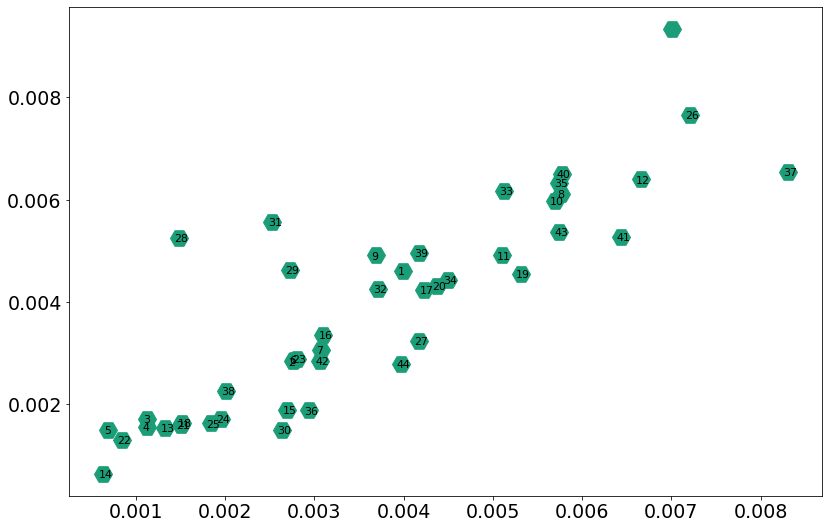

In [36]:
# Comparing d_LWP/d_GMT from GCM with d_LWP/d_GMT from ccf:
# plot settings:
parameters = {'axes.labelsize': 24, 'legend.fontsize': 14, 
       'axes.titlesize': 23, 'xtick.labelsize': 19, 'ytick.labelsize': 19}
plt.rcParams.update(parameters)

n_name = range(1, 45, 1)
Array_1 = []  # Predict
Array_2 = []   # Report
# Plotting:
plt.figure( figsize = np.array([9,6])*1.5)

for o in range(len(deck2)):
    # if (o!= 23) & (o!= 27):
    Array_1 = np.append(Array_1, output_dLWPdGMT_predicted[deck_nas2[o]])
    Array_2 = np.append(Array_2, output_dLWPdGMT_report[deck_nas2[o]])
    cltg1 = plt.scatter(output_dLWPdGMT_predicted[deck_nas2[o]], output_dLWPdGMT_report[deck_nas2[o]], s = 324, marker = 'H', color = '#1b9e77')
    Numannote1 = plt.annotate(n_name[o], xy=(output_dLWPdGMT_predicted[deck_nas2[o]], output_dLWPdGMT_report[deck_nas2[o]]), 
                xytext=(-4.60, -3.42), textcoords = "offset points", color = 'black', fontsize = 11)

plt.xlabel(r"$dLWP/dGMT|\ _{predicted\ by\ CCF},\ g\ m^{-2}\ K^{-1}$")
plt.ylabel(r"$dLWP/dGMT|\ _{predicted\ by\ GCM},\ g\ m^{-2}\ K^{-1}$")

plt.xlim([-0.0020, 0.0127])
plt.ylim([-0.0020, 0.0127])

x = linspace(-0.0008, 0.0123, 50)

y = x
plt.plot(x, y, linestyle = '--', color = 'blue', linewidth=3.4, label = " 1-1 line")
print(calc_r2(Array_1, Array_2), pearsonr(Array_1, Array_2))
plt.annotate([r'$R^{2} = %.2f$'% pearsonr(Array_1, Array_2)[0]**2], xy = (0.007678, 0.002343), fontsize = 19)
plt.title(r"$ \frac{dLWP}{dGMT}\ of\ GCMs'\ regression\ and\ CCF\ prediction$")
# plt.savefig(path6+ "plot_dLWPdGMT_actualv.spredicted_Aug30th(#44).jpg", bbox_inches ='tight', dpi = 100)

0.12334847486228821 0.46761315345577964
[-0.37121106 -0.73871883  0.67349176  1.22573322  0.77802462 -0.31174172
 -0.39810133 -0.60913995 -0.23841258 -0.4843069  -0.68979428 -1.03673005
  0.57858656  0.57719247 -0.81921693 -0.30931024 -1.23431792 -1.0655285
 -1.49009889 -0.96583631  0.23554069  1.54398895 -0.37311061 -0.23991841
 -0.33942854 -0.48240541 -0.86405368 -0.68003444 -0.68517493  1.11259968
 -0.28329908 -0.15335296 -1.07958051 -1.0478266  -0.95564785 -0.46673296
 -1.04422785 -0.07066186 -0.16055743 -0.60282951 -0.35090187 -0.93316637
 -1.58119629 -0.04675779 -1.25980679 -0.4607997  -1.50347022 -0.66614505
 -1.47137479 -1.5303042 ]
Pearsonr Correlation coeffcient:  -0.5716633324008953
p value:  1.4487526008936329e-05
Pearsonr Correlation coeffcient:  -0.5537533969444339
p value:  3.025843894153341e-05


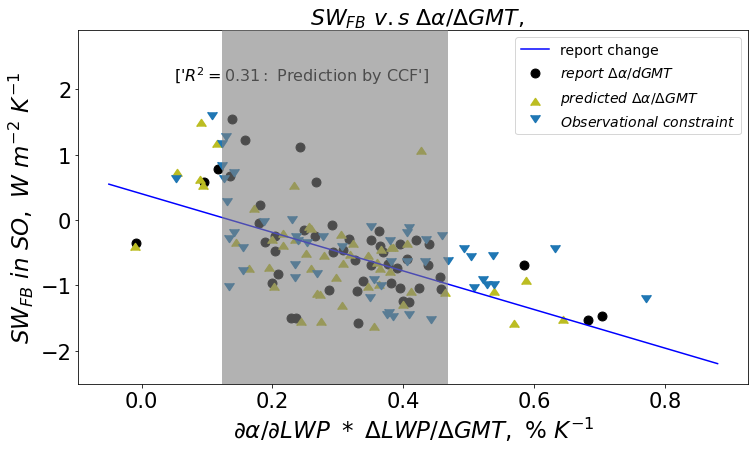

In [60]:
# plot:
parameters = {'axes.labelsize': 23, 'legend.fontsize': 14,
         'axes.titlesize': 22,  'xtick.labelsize': 21,  'ytick.labelsize':21 }
plt.rcParams.update(parameters)

plt.figure( figsize = (12, 6.5))

from scipy.optimize import curve_fit

def target_func(x, m, k):
    
    '''
    1-d line linear fit
    '''
    y = m*x + k
    return y
    
# data 

# sw_cld_fb from Dr. Mark Zelinka:
SW_FB = []
Y_report_metrics = []
Y_predicted_metrics = []
Y_OBS_constraint_metrics = []

SW_FB_5085 = []
SW_FB_4050 = []
for i in range(len(deck2)):
    # 30
    #if (i!= 23) & (i != 27):
    for j in range(len(SO_sw_cldfb)):
        # 50
        if (deck2[i]['modn']== model_nas[j]):
            # if (i in modelconstraintbystep1_nas):
            SW_FB = np.append(SW_FB, SO_sw_cldfb[j])
            SW_FB_4050 = np.append(SW_FB_4050, SO_sw_cldfb_4050[j])
            SW_FB_5085 = np.append(SW_FB_5085, SO_sw_cldfb_5085[j])
            # print(deck2[i]['modn'])

# sw_cre / SW_down:
for i in range(len(deck_nas2)):
    # if (i in modelconstraintbystep1_nas):
    Y_predicted_metrics = np.append(Y_predicted_metrics, 100.* output_dalbedo_predicted[deck_nas2[i]])
    Y_report_metrics = np.append(Y_report_metrics, 100.* output_dalbedo_report[deck_nas2[i]])
    Y_OBS_constraint_metrics = np.append(Y_OBS_constraint_metrics, 100.* output_dalbedo_OBSconstraintonGCM[deck_nas2[i]])
    
x1_albedoc = (100. * np.min(delta_albedo_LWP_OBS_warm))
x2_albedoc = (100. * np.max(delta_albedo_LWP_OBS_warm))
x1 = (100. / 1000. * 0.825) * 2.6851731008618875
x2 = (100. / 1000. * 0.825) * 3.9123598750390185
print(x1_albedoc, x2_albedoc)

SW_FB = np.asarray(SW_FB)
Y_report_metrics = np.asarray(Y_report_metrics) 
Y_predicted_metrics = np.asarray(Y_predicted_metrics)
print(SW_FB)

# Plotting

plt.scatter(Y_report_metrics, SW_FB, marker = 'o', c = 'black', s = 80, label = r'$report\ \Delta \alpha /dGMT$')
plt.scatter(Y_predicted_metrics, SW_FB, marker = 6, c = 'tab:olive', s = 92, label = r'$ predicted\ \Delta \alpha/ \Delta GMT$')

# plt.scatter(Y_predicted_metrics[12], SW_FB[12] + 0.05, marker = 6, c = 'red', s= 93)
# plt.scatter(Y_predicted_metrics[26], SW_FB[26] + 0.05, marker = 6, c = 'pink', s= 93)

# plt.scatter(Y_report_metrics[12], SW_FB[12], marker = 'o', c = 'red', s= 84, label = 'EC-Earth3')
# plt.scatter(Y_report_metrics[26], SW_FB[26], marker = 'o', c = 'pink', s= 84, label = 'NESM3')
plt.scatter(Y_OBS_constraint_metrics, SW_FB, marker = 7, c = 'tab:blue', s = 94, label = r'$Observational\ constraint$')
plt.axvspan(x1_albedoc, x2_albedoc, np.min(SW_FB), np.max(SW_FB), facecolor = 'gray', alpha = 0.6, zorder = 9)

# plt.xlim([-0.25, 0.90]) # [-0.40, 1.20]
plt.ylim([-2.50, 2.90])

plt.xlabel(r"$ \partial \alpha/ \partial LWP\ *\ \Delta LWP/ \Delta GMT,\ \%\ K^{-1} $")
plt.ylabel(r"$ SW_{FB}\ in\ SO,\ W\ m^{-2}\ K^{-1} $")

'''
for j in range(len(deck2)):
    plt.annotate(np.arange(1, 51, 1)[j], xy = (Y_report_metrics[j], SW_FB[j]), xytext=(-0.0862, -0.0342), textcoords = "offset points", fontsize = 12)
    # plt.annotate(n_name[j], xy = (Y_predicted_metrics[j], SW_FB_5085[j]), xytext=(-0.056, -0.0342), textcoords = "offset points", fontsize = 12)
'''

# fitting line:
x = np.linspace(-0.05, 0.88, 37)
# y = np.linspace(-2.50, 4.5, 19)


POPT_SWfb, POCV_SWfb = curve_fit(target_func, Y_predicted_metrics, SW_FB)
fitp1 = plt.plot(x, (POPT_SWfb[0] * x + POPT_SWfb[1]), c = 'b', label = "report change")
# print(POPT_SWfb)

# POPT_SWfbpredi, POCV_SWfbpredi = curve_fit(target_func, Y_predicted_metrics, SW_FB)
# fitp2 = plt.plot(x, (POPT_SWfbpredi[0] * x + POPT_SWfbpredi[1]), c = 'black', label = "fitting line", linewidth = 2.2)

plt.legend(loc = 'best')
plt.title(r"$\ SW_{FB}\ v.s\ \Delta \alpha / \Delta GMT,\ $" + r'')
plt.annotate([r'$ R^{2} = %.2f :$' %pearsonr(Y_predicted_metrics, SW_FB)[0]**2+' Prediction by CCF'], xy = (0.85-0.80, 2.13), fontsize = 16) 
# plt.annotate([r'$ R^{2} = %.2f :$' %pearsonr(Y_report_metrics, SW_FB)[0]**2+' Prediction by GCM'], xy = (0.85-0.80, 2.13- 0.30), fontsize = 16) 

# # plt.show()
print('Pearsonr Correlation coeffcient: ', pearsonr(Y_report_metrics, SW_FB)[0])
print('p value: ', pearsonr(Y_report_metrics, SW_FB)[1])

print('Pearsonr Correlation coeffcient: ', pearsonr(Y_predicted_metrics, SW_FB)[0])
print('p value: ', pearsonr(Y_predicted_metrics, SW_FB)[1])

# plt.savefig(path6+"SWfb_vs_Janalphachanges_Sep30th.jpg", bbox_inches = 'tight', dpi = 400)

In [21]:
# plot:
parameters = {'axes.labelsize': 22, 'legend.fontsize': 19,
         'axes.titlesize': 18,  'xtick.labelsize': 21,  'ytick.labelsize':21 }
plt.rcParams.update(parameters)

plt.figure( figsize = (12, 6.5))

from scipy.optimize import curve_fit

def target_func(x, m, k):
    
    '''
    1-d line linear fit
    '''
    y = m*x + k
    return y

# data

# sw_cld_fb from Mark Zelinka:
X_metrics = np.zeros((12))
order_of_GCM = [4, 14, 6, 7, 8, 13, 22, 23, 29, 34, 31, 39]

# sw_cre / SW_down:
Y_metrics = []
Y_report_metrics = []

for i in range(len(deck_nas2)):
    
    X_metrics[i] = SO_sw_cldfb[order_of_GCM[i]]
    Y_metrics = np.append(Y_metrics, 100.* output_dswcre_predicted[deck_nas2[i]])
    Y_report_metrics = np.append(Y_report_metrics, 100.* output_dswcre_report[deck_nas2[i]])

print(Y_metrics)
X_metrics = np.asarray(X_metrics)
Y_metrics = np.asarray(Y_metrics)

# Plotting
plt.scatter(Y_report_metrics, X_metrics, marker = '^', c = 'k', s = 35, label = r'$report\ drsut /dGMT$')
plt.scatter(Y_metrics, X_metrics, marker = '*', c = 'g', s = 40, label = r'$ predicted\ drsut /dGMT$')

plt.xlim([-45., 175]) # [-0.40, 1.20]  [-0.20, 0.80]
plt.ylim([-1.90, 2.50])
plt.xlabel(r"$ \partial \alpha/ \partial  LWP\ *\ dLWP/dGMT\ *rsdt,\ W\ m^{-2}\ K^{-1} $")
plt.ylabel(r"$ SW_{FB}\ in\ SO,\ W\ m^{-2}\ K^{-1} $")
# plt.legend()

# fitting line:
x = np.linspace(-50, 165, 25) # (-0.50, 1.20)
# y = np.linspace(-1.50, 2.0, 19)

POPT_SWfb, POCV_SWfb = curve_fit(target_func, Y_report_metrics, X_metrics)
fitp1 = plt.plot(x, (POPT_SWfb[0] * x + POPT_SWfb[1]), c = 'b', label = "report change")
print(POPT_SWfb)

POPT_SWfbpredi, POCV_SWfbpredi = curve_fit(target_func, Y_metrics, X_metrics)
fitp2 = plt.plot(x, (POPT_SWfbpredi[0] * x + POPT_SWfbpredi[1]), c = 'green', label = "predicted change")

plt.legend()
plt.title(r"$(A)\ SW_{fb}\ v.s\ \Delta rsut / \Delta GMT,\ $" + 'with albedo_cs <= 0.10')
# plt.show()
print('Pearsonr Correlation coeffcient: ', pearsonr(Y_report_metrics, X_metrics)[0])
print('p value: ', pearsonr(Y_report_metrics, X_metrics)[1])

print('Pearsonr Correlation coeffcient: ', pearsonr(Y_metrics, X_metrics)[0])
print('p value: ', pearsonr(Y_metrics, X_metrics)[1])

# plt.savefig(path6+"SWfb_vs_rsutchanges_thres0.10.jpg")

NameError: name 'output_dswcre_predicted' is not defined

<Figure size 864x468 with 0 Axes>

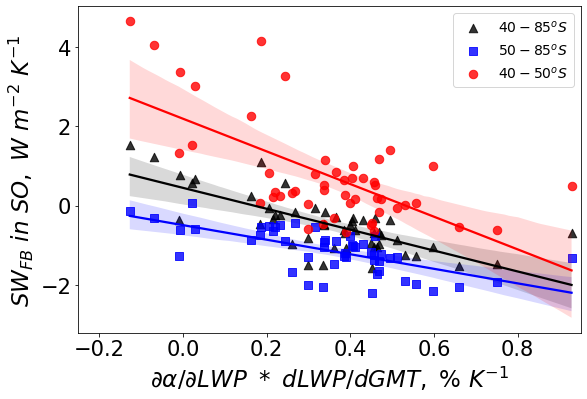

In [28]:
import seaborn as sna

# sw_cld_fb from Dr. Mark Zelinka:
SW_FB = [None]* len(deck2)
SW_FB_5085 = [None]* len(deck2)
SW_FB_4050 = [None]* len(deck2)

for i in range(len(deck2)):
    # 30
    for j in range(len(SO_sw_cldfb)):
        # 50
        if deck2[i]['modn']== model_nas[j]:
            SW_FB[i] = SO_sw_cldfb[j]
            SW_FB_4050[i] = SO_sw_cldfb_4050[j]
            SW_FB_5085[i] = SO_sw_cldfb_5085[j]
            
plt.figure( figsize = (9, 6))

sns.regplot(x = Y_report_metrics, y = SW_FB, color = 'black', marker = '^', ci = 95, scatter_kws={"s": 72}, label = r'$40 - 85^{o}S$')

sna.regplot(x = Y_report_metrics, y = SW_FB_5085, color = 'blue', marker = 's', ci = 95, scatter_kws={"s": 72}, label = r'$50 - 85^{o}S$')
sns.regplot(x = Y_report_metrics, y = SW_FB_4050, color = 'red', marker = 'o',ci = 95, scatter_kws={"s": 72}, label = r'$40 - 50^{o}S$')

plt.xlim([-0.25, 0.95])
plt.ylabel(r"$ SW_{FB}\ in\ SO,\ W\ m^{-2}\ K^{-1} $")
plt.xlabel(r"$ \partial \alpha/ \partial LWP\ *\ dLWP/ dGMT,\ \%\ K^{-1} $")
plt.legend()

# plt.savefig(path6 + "SWFBv.sDeltaalbedo_Jan_DeltaLWP_DeltaGMT_reportchange_Aug15th.jpg", dpi = 250)

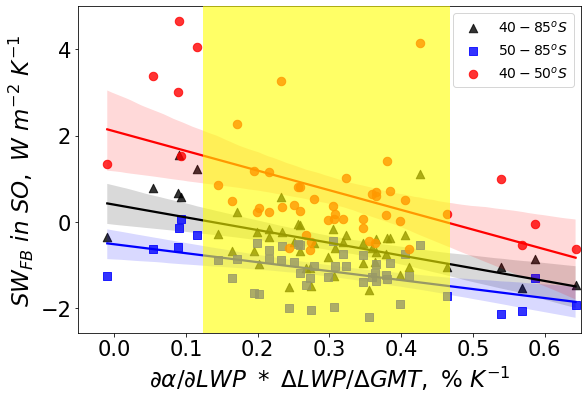

In [63]:
import seaborn as sna

# sw_cld_fb from Dr. Mark Zelinka:
SW_FB = [None]* len(deck2)
SW_FB_5085 = [None]* len(deck2)
SW_FB_4050 = [None]* len(deck2)

for i in range(len(deck2)):
    # 30
    for j in range(len(SO_sw_cldfb)):
        # 50
        if deck2[i]['modn']== model_nas[j]:
            SW_FB[i] = SO_sw_cldfb[j]
            SW_FB_4050[i] = SO_sw_cldfb_4050[j]
            SW_FB_5085[i] = SO_sw_cldfb_5085[j]
            
plt.figure( figsize = (9, 6))

sns.regplot(x = Y_predicted_metrics, y = SW_FB, color = 'black', marker = '^', ci = 95, scatter_kws={"s": 72}, label = r'$40 - 85^{o}S$')

sna.regplot(x = Y_predicted_metrics, y = SW_FB_5085, color = 'blue', marker = 's', ci = 95, scatter_kws={"s": 72}, label = r'$50 - 85^{o}S$')
sns.regplot(x = Y_predicted_metrics, y = SW_FB_4050, color = 'red', marker = 'o',ci = 95, scatter_kws={"s": 72}, label = r'$40 - 50^{o}S$')
plt.axvspan(x1_albedoc, x2_albedoc, np.min(SW_FB), np.max(SW_FB), facecolor = 'yellow', alpha = 0.60, zorder = 9)

plt.xlim([-0.05, 0.65])
plt.ylabel(r"$ SW_{FB}\ in\ SO,\ W\ m^{-2}\ K^{-1} $")
plt.xlabel(r"$ \partial \alpha/ \partial LWP\ *\ \Delta LWP/ \Delta GMT,\ \%\ K^{-1} $")
plt.legend()

# plt.savefig(path6 + "SWFBv.sDeltaalbedo_Jan_DeltaLWP_DeltaGMT_predictedchange_Oct4th.jpg", bbox_inches = 'tight', dpi = 400)